In [ ]:
# We import the neccessary packages in the beginning
import datetime
import os
import math
import statistics
import numpy as np
import pandas as pd
from statistics import mean,stdev
import graphviz
import time 
import pm4py
#from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py import conformance_diagnostics_alignments as alignments
from pm4py.algo.conformance.tokenreplay import algorithm as token_based_replay
#from pm4py.algo.filtering.log.auto_filter.auto_filter import apply_auto_filter
from pm4py.statistics.attributes.log.get import get_attribute_values
from pm4py.statistics.attributes.log.get import get_all_trace_attributes_from_log
from pm4py.statistics.attributes.log.get import get_all_event_attributes_from_log
from pm4py.statistics.attributes.log.get import get_trace_attribute_values
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.conversion.bpmn import converter as bpmn_converter
from sklearn import linear_model
from sklearn import tree
from sklearn.impute import SimpleImputer
#from pm4py.visualization.petri_net import visualizer as pn_visualizer
import statsmodels.api as sm
#import pygraphviz
from pm4py.objects.log.obj import EventLog, Trace, EventStream
#Causality Toolbox
import networkx as nx
import torch
import torchvision
import matplotlib.pyplot as plt
from random import randint, choice
import copy
import random
import itertools
import pkgutil
from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imblearn.under_sampling import OneSidedSelection
from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import sklearn
from sklearn.tree import DecisionTreeClassifier
import tqdm
import time
import xgboost as xgb

In [ ]:
# Returns a path to the file selected by the user
# Input: The folder in which to look for the files - the default is the current folder
def ask_for_path(rel_path='', index = -1):
    #Crawl all files in the input folder
    print("The following files are available in the input folder:\n")

    count = 0
    file_list = os.listdir(os.getcwd() + rel_path)
    for file in file_list:
        print(str(count) + " - " + file)
        count+=1

    if(index == -1):
        #Ask for which of the files shall be transformed and select it.
        inp = input("Please choose from the list above which of the files shall be transformed by typing the corresponding number.")
    else:
        #Automatic iteration
        print('Automatic Iteration.')
        inp = index

    input_file = file_list[int(inp)]

    return (os.getcwd() + rel_path + input_file)

In [ ]:
# this is a help function to print petri nets
def output_petri_net(net, initial_marking, final_marking, file_name, label):

    #init visualizer
    parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: OUTPUT_FORMAT, 'label':'The Round Table'}   #Add frequency to graph
    gviz = pn_visualizer.apply(net, initial_marking, final_marking, parameters=parameters,
                               variant=pn_visualizer.Variants.FREQUENCY, log=log)

    gviz.attr(label=label)
    pn_visualizer.save(gviz, os.getcwd() + REL_OUTPUT_PATH + file_name + "." + OUTPUT_FORMAT)

In [ ]:
def get_output_path(file_name,REL_OUTPUT_PATH = "/Output Tree/"):
    return (os.getcwd() + REL_OUTPUT_PATH + file_name)

In [ ]:
# this function converts a selected file in the path that is the input into a log
def transform_to_log(file_path):
    filename, file_extension = os.path.splitext(file_path)
    x,z =os.path.split(file_path)
    
    if file_extension == '.csv':
        log_csv = pd.read_csv(file,sep=None,encoding='utf-8-sig')
        if z =='mobis_challenge_log_2019.csv' or z =='mobis_challenge_log_2019_only_complete_cases.csv':
            log_csv['end'] = pd.to_datetime(log_csv['end'])
            log_csv['start'] = pd.to_datetime(log_csv['start'])
            log_csv['cost'] = log_csv['cost'].apply(pd.to_numeric, errors='coerce')
            log_csv.rename(columns={'cost': 'case:cost','case':'case:concept:name','activity':'concept:name','end':'time:timestamp', 'user':'org:resource'}, inplace=True)
        log_csv['time:timestamp'] = pd.to_datetime(log_csv['time:timestamp'])
        log = log_converter.apply(log_csv)
    elif file_extension == '.xes':
        log = pm4py.read_xes(file_path)
        log = pm4py.convert_to_event_log(log)
    elif file_extension == '.dfg':
        log = pm4py.read_dfg(file_path)
    else:
        print("Current filetype is equal to {}. \nPlease input a file with any of the following extensions: - csv; - xes; - dfg".format(str(file_extension)))
        return -1

    return log

In [ ]:
def get_all_activities_from_log(log):
    activities=[]
    for trace in log:
        for event in trace:
            if activities.count(event['concept:name'])==0:
                activities.append(event['concept:name'])
    return activities

In [ ]:
# this function enriches each trace by the event 1...m, resource 1...m, Weekday start and end attributes until a given prefix length
def complex_index_encoding(log, pref_length=5):
    max_ev=0
    for trace in log:
        i=0
        for event in trace:
            i+=1
        if i>max_ev:
            max_ev=i
    
    if pref_length > max_ev:
        print('The prefix length is larger than the maximum trace length; Maximum trace length will be used.')
        pref_length = max_ev

    #weekdays
    weekDaysMapping = ("Monday", "Tuesday",
                    "Wednesday", "Thursday",
                    "Friday", "Saturday",
                    "Sunday")

    for trace in log:
        for event in trace:
            trace.attributes['weekday_start']=weekDaysMapping[event['time:timestamp'].weekday()]
            break
    if pref_length == max_ev:
        for trace in log:
            for event in trace:
                trace.attributes['weekday_end']=weekDaysMapping[event['time:timestamp'].weekday()]
    
    
    j=0
    no_evs={}
    for trace in log:
        i=0
        for event in trace:
            i+=1
            if i==1:
                st_time=event['time:timestamp'].day+event['time:timestamp'].hour/24+event['time:timestamp'].minute/(24*60)
            if i<= pref_length:
                trace.attributes['event_'+str(i)]=event['concept:name']
                trace.attributes['resource_'+str(i)]=str(event['org:resource'])
                trace.attributes['month_'+str(i)]=(str(event['time:timestamp'].month)+'_'+str(event['time:timestamp'].year))
                #trace.attributes['elapsed_time']=event['time:timestamp'].day+event['time:timestamp'].hour/24+event['time:timestamp'].minute/(24*60)-st_time
        no_evs[j]=i
        j+=1

    j=0
    for trace in log:
        if no_evs[j]<max_ev:
            fill=no_evs[j]+1
            for k in range(fill,max(max_ev,pref_length)+1):
                trace.attributes['event_'+str(k)]=np.nan
                trace.attributes['resource_'+str(k)]=np.nan

    return log

In [ ]:
import caffeine

In [ ]:
##########
"""Settings"""
##########
# set the input and output path according to the files you want to select
REL_INPUT_PATH = "/../BPIC12/" # here lie the event logs (.csv), the to-be model (.bpmn) and the already aligned traces (.pkl)
REL_OUTPUT_PATH = "/BPIC12/"
OUTPUT_FORMAT = "png"

In [174]:
# generate the log from the input path
file= ask_for_path(REL_INPUT_PATH,14) # adjust to your path
log=transform_to_log(file)
ref_log=transform_to_log(file)


The following files are available in the input folder:

0 - Model_A_corrected_BPMN.svg
1 - MPPN_BPIC_2012_O_deviation_detection_pd_cases_fv.pkl
2 - Model_AO_corrected.bpmn
3 - Model_A.bpmn
4 - .DS_Store
5 - Model_AO.bpmn
6 - Model_A.pnml
7 - Model_AO.pnml
8 - Model_O.cpn
9 - BPI_Challenge_2012 (1).xes.gz
10 - aligned_traces_12AO.pkl
11 - Basis_PN.png
12 - aligned_traces_12O.pkl
13 - Model_A_corrected_BPMN.png
14 - BPIC12_Log_onlyA.csv
15 - MPPN_BPIC_2012_A_deviation_detection_pd_cases_fv.pkl
16 - BPIC12_Log_onlyAO.csv
17 - Model_O.pnml
18 - aligned_traces_12AO_corrected.pkl
19 - BPIC12_Log_onlyO.csv
20 - Model_AO.cpn
21 - Model_A_corrected.bpmn
22 - aligned_traces_12A.pkl
23 - logcpn_enriched_duration_trace_attribute_labels.xes
24 - BPI_Challenge_2012.xes
25 - MPPN_BPIC_2012_A_deviation_detection_suffixe.pkl
26 - Model_A.cpn
27 - Model_A_corrected_PN.png
28 - Model_A_corrected.pnml
29 - MPPN_BPIC_2012_O_deviation_detection_suffixe.pkl
30 - Model_O.bpmn
Automatic Iteration.


Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.


The following files are available in the input folder:

0 - Model_A_corrected_BPMN.svg
1 - MPPN_BPIC_2012_O_deviation_detection_pd_cases_fv.pkl
2 - Model_AO_corrected.bpmn
3 - Model_A.bpmn
4 - .DS_Store
5 - Model_AO.bpmn
6 - Model_A.pnml
7 - Model_AO.pnml
8 - Model_O.cpn
9 - BPI_Challenge_2012 (1).xes.gz
10 - aligned_traces_12AO.pkl
11 - Basis_PN.png
12 - aligned_traces_12O.pkl
13 - Model_A_corrected_BPMN.png
14 - BPIC12_Log_onlyA.csv
15 - MPPN_BPIC_2012_A_deviation_detection_pd_cases_fv.pkl
16 - BPIC12_Log_onlyAO.csv
17 - Model_O.pnml
18 - aligned_traces_12AO_corrected.pkl
19 - BPIC12_Log_onlyO.csv
20 - Model_AO.cpn
21 - Model_A_corrected.bpmn
22 - aligned_traces_12A.pkl
23 - logcpn_enriched_duration_trace_attribute_labels.xes
24 - BPI_Challenge_2012.xes
25 - MPPN_BPIC_2012_A_deviation_detection_suffixe.pkl
26 - Model_A.cpn
27 - Model_A_corrected_PN.png
28 - Model_A_corrected.pnml
29 - MPPN_BPIC_2012_O_deviation_detection_suffixe.pkl
30 - Model_O.bpmn
Automatic Iteration.


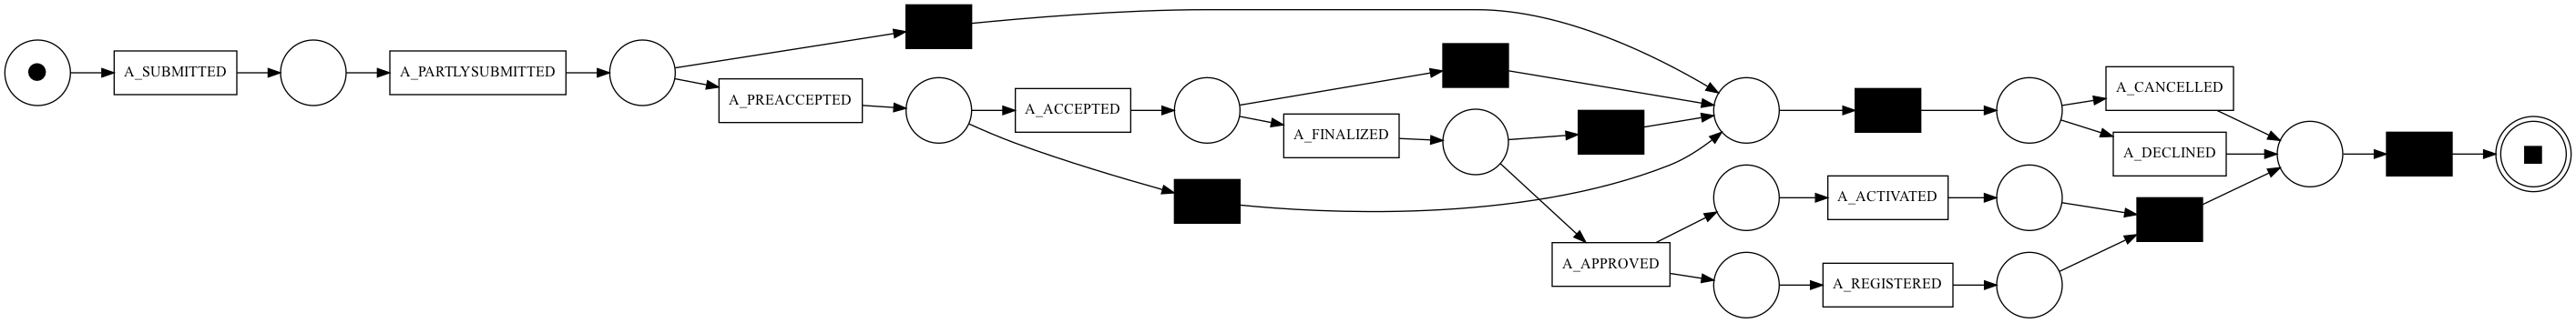

In [175]:
file= ask_for_path(REL_INPUT_PATH,21)# adjust to your path
bpmn_graph = pm4py.read_bpmn(file)
#pm4py.write_bpmn(bpmn_graph, "ru.bpmn", enable_layout=True)
net, initial_marking, final_marking = bpmn_converter.apply(bpmn_graph)
#net, initial_marking, final_marking=pm4py.read_pnml(file)
# pm4py.visualization.petri_net.visualizer(net, initial_marking, final_marking)
# output_petri_net(net, initial_marking, final_marking,'Basis_PN', 'test')
pm4py.view_petri_net(net, initial_marking, final_marking)

In [176]:
def generate_alignments_pkl(log, net, initial_marking, final_marking):
    aligned_traces = pm4py.conformance_diagnostics_alignments(log, net, initial_marking, final_marking)
    i=0
    dev=[]
    for trace in log:
        no_moves=len(aligned_traces[i]['alignment'])
        for j in range(0,len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
                next
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
                #trace.attributes[str(aligned_traces[i]['alignment'][j])]=1
        i+=1

    f = open('aligned_traces_mobis_complete.pkl','wb')
    pickle.dump(aligned_traces,f)
    f.close()
    return dev

In [177]:
file= ask_for_path(REL_INPUT_PATH,22)# adjust to your path
with open(file, 'rb') as f:
    aligned_traces=pickle.load(f)

The following files are available in the input folder:

0 - Model_A_corrected_BPMN.svg
1 - MPPN_BPIC_2012_O_deviation_detection_pd_cases_fv.pkl
2 - Model_AO_corrected.bpmn
3 - Model_A.bpmn
4 - .DS_Store
5 - Model_AO.bpmn
6 - Model_A.pnml
7 - Model_AO.pnml
8 - Model_O.cpn
9 - BPI_Challenge_2012 (1).xes.gz
10 - aligned_traces_12AO.pkl
11 - Basis_PN.png
12 - aligned_traces_12O.pkl
13 - Model_A_corrected_BPMN.png
14 - BPIC12_Log_onlyA.csv
15 - MPPN_BPIC_2012_A_deviation_detection_pd_cases_fv.pkl
16 - BPIC12_Log_onlyAO.csv
17 - Model_O.pnml
18 - aligned_traces_12AO_corrected.pkl
19 - BPIC12_Log_onlyO.csv
20 - Model_AO.cpn
21 - Model_A_corrected.bpmn
22 - aligned_traces_12A.pkl
23 - logcpn_enriched_duration_trace_attribute_labels.xes
24 - BPI_Challenge_2012.xes
25 - MPPN_BPIC_2012_A_deviation_detection_suffixe.pkl
26 - Model_A.cpn
27 - Model_A_corrected_PN.png
28 - Model_A_corrected.pnml
29 - MPPN_BPIC_2012_O_deviation_detection_suffixe.pkl
30 - Model_O.bpmn
Automatic Iteration.


In [178]:
## train data
class TrainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

## test data    
class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [179]:
# we define our FFN 
class BinaryClassificationIndiv(nn.Module):
    def __init__(self, no_columns):
        super(BinaryClassificationIndiv, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(no_columns, 256)
        self.activation1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(256, 256)
        self.activation2 = nn.LeakyReLU()
        self.layer_out = nn.Linear(256, 2)
        
        
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.LayerNorm(256)
        self.batchnorm2 = nn.LayerNorm(256)
        self.Softmax = nn.Softmax()
        
    def forward(self, inputs):
        x = self.activation1(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.activation2(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        
        return x

In [180]:
class LargerBinaryClassificationIndiv(nn.Module):
    def __init__(self, no_columns):
        super(LargerBinaryClassificationIndiv, self).__init__()
        self.layer_1 = nn.Linear(no_columns, 512)
        self.activation1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(512, 256)
        self.activation2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(256, 256)
        self.activation3 = nn.LeakyReLU()
        self.layer_out = nn.Linear(256, 2)


        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.LayerNorm(512)
        self.batchnorm2 = nn.LayerNorm(256)
        self.Softmax = nn.Softmax()

    def forward(self, inputs):
        x = self.activation1(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.activation2(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.activation3(self.layer_3(x))
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [181]:
class EarlyStopping():
  def __init__(self, patience=15, min_delta=0, restore_best_weights=True):
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_weights = restore_best_weights
    self.best_model = None
    self.best_loss = None
    self.counter = 0
    self.status = ""
    
  def __call__(self, model, val_loss):
    if self.best_loss == None:
      self.best_loss = val_loss
      self.best_model = copy.deepcopy(model)
    elif self.best_loss - val_loss > self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
      self.best_model.load_state_dict(model.state_dict())
    elif self.best_loss - val_loss <= self.min_delta:
      self.counter += 1
      if self.counter >= self.patience:
        self.status = f"Stopped on {self.counter}"
        if self.restore_best_weights:
          model.load_state_dict(self.best_model.state_dict())
        return True
    self.status = f"{self.counter}/{self.patience}"
    return False

In [182]:
# just for printing the accuracy during training - only informational
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.nn.functional.softmax(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [183]:
def BPDP_classification_CIBE(log, ref_log, aligned_traces, split=1/3, u_sample=True, early_stop=True,explained=False):
    xt,z =os.path.split(file)

    #### get information whether deviation happened after prefix length in DF
    i=0
    dev=[] # stores all deviations that happened
    for trace in log:
        no_moves=len(aligned_traces[i]['alignment'])
        for j in range(0,len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
                next # we do not care for simultaneous or silent moves
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
        i+=1

    y_cum_test={} # dict that stores label for each prefix and deviation combinations; keys are prefix length, entries are Data Frames with index = trace and columns = deviation
    dev_df=pd.DataFrame(data=0,columns=dev, index=range(len(log))) # Data Frame that stores the information whether a deviation happened for each trace on trace level
    event_order={} # dict with event sequences for each trace
    event_count={} # dict with trace length for each trace
    max_ev=0 # will be maximum trace length
    k=0
    for trace in log:
        event_order[k]=[]
        i=0
        for event in trace:
            i+=1
            event_order[k].append(event['concept:name'])
        if i>max_ev:
            max_ev=i
        event_count[k]=len(event_order[k])
        k+=1
    i=0
    for trace in log:
        no_moves=len(aligned_traces[i]['alignment'])
        for j in range(0,len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
                next
            else:
                dev_df[str(aligned_traces[i]['alignment'][j])][i]=1
        i+=1
    for ev in range(1,max_ev+1):
        y_cum_test[ev]=dev_df.copy() # initialize each prefix length with all traces and information whether deviation happened
    for ev in range(1,max_ev+1):
        drop_idx=[]
        for trace_idx in range(len(log)):
            if event_count[trace_idx]< ev:
                drop_idx.append(trace_idx) # drop all trace labels that do not go until prefix length
        y_cum_test[ev]=y_cum_test[ev].drop(drop_idx)
    i=0
    for trace in log:
        no_moves=len(aligned_traces[i]['alignment'])
        j=no_moves-1 # iterator over moves in alignment, starting at the end
        m=len(event_order[i]) # iterator over event sequence, starting at the end
        while j >=0:
            if aligned_traces[i]['alignment'][j][1] == None: # if silent move, just go one move further to the beginning in the alignment
                j-=1
            elif aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
                if event_order[i][m-1]==aligned_traces[i]['alignment'][j][0]: # if synchronous move, just go one move further to the beginning in the alignment and one event forther to the beginning in the event sequence
                    j-=1
                    m-=1
            elif event_order[i][m-1]==aligned_traces[i]['alignment'][j][0]: # log move detected
                for q in range(m,max_ev+1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][i]=0 # set all prefixes from the current m to the maximum prefix length in this trace to 0 because deviation happened here but not afterwards
                j-=1
                m-=1
            elif m==max_ev:
                j-=1
            else: # model move deteceted
                for q in range(m+1,max_ev+1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][i]=0 # set all prefixes after the current m to the maximum prefix length in this trace to 0 because deviation happened between m and m+1 but not afterwards
                j-=1
        i+=1
    ### y_cum_test holds information whether deviation happened after prefix length


    ## ref_log will have all attributes that will be the columns for X_test and X_train
    ref_log = complex_index_encoding(ref_log, 4000) # prepare a log with the maximum length of the feature vector from CIBE to know to pad other feature vectors
    ref_dataframe1 = pm4py.convert_to_dataframe(ref_log)
    ref_dataframe=ref_dataframe1.drop_duplicates(subset=['case:concept:name'])
    ref_dataframe=ref_dataframe.filter(like='case:', axis=1)
    ref_dataframe=ref_dataframe.drop('case:concept:name', axis=1)
    ref_dataframe.columns = ref_dataframe.columns.str.replace(r'^case:', '')
    ref_dataframe=ref_dataframe.reset_index()
    ref_raw_dat=ref_dataframe.drop('index', axis=1)
    ## dataset-specific preparation (i.e., redundant attributes, convertion to numeric)
    if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
        ref_raw_dat['AMOUNT_REQ']= pd.to_numeric(ref_raw_dat['AMOUNT_REQ'])
        ref_clean_dat=ref_raw_dat.drop('REG_DATE', axis=1)
    elif z=='aligned_traces_20int.pkl':
            ref_clean_dat=ref_raw_dat.drop(['Permit travel permit number','DeclarationNumber','travel permit number','id','Permit ID', 'Permit id'], axis=1)
    elif z=='aligned_traces_20dom.pkl':
            ref_clean_dat=ref_raw_dat.drop(['DeclarationNumber','id'], axis=1)
    elif z=='aligned_traces_20prep.pkl':
            ref_clean_dat=ref_raw_dat.drop(['RfpNumber','Rfp_id','Permit travel permit number','Permit id'], axis=1)
    elif z=='aligned_traces_20RfP.pkl':
            ref_clean_dat=ref_raw_dat.drop(['RfpNumber','Rfp_id'], axis=1)
    else:
        ref_clean_dat=ref_raw_dat.copy()
    ref_enc_dat=pd.get_dummies(ref_clean_dat)



    EPOCHS = 30
    BATCH_SIZE = 128
    LEARNING_RATE=0.0001

    X_cum={}
    metrics=pd.DataFrame(data=0, columns=dev, index=['Precision', 'Recall', 'Support', 'ROC_AUC'])

    # prepare X for all prefix lengths
    for prefix in range(1,max_ev+1):
        complex_index_encoding(log,prefix)
        dataframe1 = pm4py.convert_to_dataframe(log)
        dataframe=dataframe1.drop_duplicates(subset=['case:concept:name'])
        dataframe=dataframe.filter(like='case:', axis=1)
        dataframe=dataframe.drop('case:concept:name', axis=1)
        dataframe.columns = dataframe.columns.str.replace(r'^case:', '')
        dataframe=dataframe.reset_index()
        raw_dat=dataframe.drop('index', axis=1)
        if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
            raw_dat['AMOUNT_REQ']= pd.to_numeric(raw_dat['AMOUNT_REQ'])
            clean_dat=raw_dat.drop('REG_DATE', axis=1)
        elif z=='aligned_traces_20int.pkl':
            clean_dat=raw_dat.drop(['Permit travel permit number','DeclarationNumber','travel permit number','id','Permit ID', 'Permit id'], axis=1)
        elif z=='aligned_traces_20dom.pkl':
            clean_dat=raw_dat.drop(['DeclarationNumber','id'], axis=1)
        elif z=='aligned_traces_20prep.pkl':
            clean_dat=raw_dat.drop(['RfpNumber','Rfp_id','Permit travel permit number','Permit id'], axis=1)
        elif z=='aligned_traces_20RfP.pkl':
            clean_dat=raw_dat.drop(['RfpNumber','Rfp_id'], axis=1)
        else:
            clean_dat=raw_dat.copy()
        enc_dat=pd.get_dummies(clean_dat)
        for key in ref_enc_dat.columns:
            if not key in enc_dat.columns:
                enc_dat[key]=0 # pad all prefixes to maximum lengths with 0
        imp = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=0)
        enc_dat=pd.DataFrame(data=imp.fit_transform(enc_dat),columns=enc_dat.columns)

        X_cum[prefix]=enc_dat.copy()
        drop_idx=[]
        for trace_idx in range(len(log)):
            if event_count[trace_idx]< prefix:
                drop_idx.append(trace_idx)

        X_cum[prefix]=X_cum[prefix].drop(drop_idx)

    positive_weights = {}
    negative_weights = {}
    for label in dev:
        positive_weights[label] = 16
        negative_weights[label] = 1

    for d in dev:
        metrics[str('NoDev'+d)]=0

    path=(os.getcwd()+'/BPDP_Classifier') # output path
    xt,z =os.path.split(file)

    writer = pd.ExcelWriter(path+'/'+z+'_BPDP_CIBE_classification.xlsx', engine="xlsxwriter")

    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)), test_size=split, random_state=0)

    dev_position = pd.DataFrame(index=x_test_idx, columns=dev, data=0)
    for d in dev:
        for idx in x_test_idx:
            for i in range(1, event_count[idx]+1):
                if y_cum_test[i][d][idx]==1: dev_position[d][idx]=i+1
    dev_position_pred = pd.DataFrame(index=x_test_idx, columns=dev, data=0)
    earliness={}

    dev_distribution = pd.DataFrame(data=0, index=['Training','Test'], columns=dev)
    for d in dev:
        dev_distribution[d]['Training']=sum(dev_df[d][i] for i in x_train_idx)
        dev_distribution[d]['Test']=sum(dev_df[d][i] for i in x_test_idx)

    dev_distribution.to_excel(writer, sheet_name=('Distribution'))

    dev_trained=[]
    for d in dev:
        if dev_distribution[d]['Training'] ==0:
            metrics[d]='No Deviation in Training Set'
            continue
        elif dev_distribution[d]['Test'] ==0:
            metrics[d]='No Deviation in Test Set'
            continue
        else:
            dev_trained.append(d)


        Y_cum_dev={}
        for prefix in range(1,max_ev+1):
            Y_cum_dev[prefix]=pd.DataFrame(y_cum_test[prefix][d])
            Y_cum_dev[prefix]['NoDev']=0
            for i in Y_cum_dev[prefix].index.values.tolist():
                Y_cum_dev[prefix]['NoDev'][i]=1-y_cum_test[prefix][d][i]
            if prefix==1:
                print(Y_cum_dev[prefix].columns)

        if u_sample:
            imb_ref_enc_dat=ref_enc_dat.copy()
            imb_ref_enc_dat['ind']=0
            for i in range(len(imb_ref_enc_dat)):
                imb_ref_enc_dat['ind'][i]=i
            imb_traces=pd.DataFrame(data=0, columns=['Dev'], index = range(len(log)))
            for trace in range(len(log)):
                if dev_df[d][trace]>0:
                    imb_traces['Dev'][trace]=1


            imb_traces=imb_traces.drop(x_test_idx)
            imb_ref_enc_dat=imb_ref_enc_dat.drop(x_test_idx)
            imp = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=0)
            imb_ref_enc_dat=pd.DataFrame(data=imp.fit_transform(imb_ref_enc_dat),columns=imb_ref_enc_dat.columns)

            oss=OneSidedSelection(random_state=0,n_seeds_S=250,n_neighbors=7)

            X_resampled, y_resampled = oss.fit_resample(imb_ref_enc_dat, imb_traces)

            x_train_idx= list(X_resampled['ind'])
            y_train_idx= list(X_resampled['ind'])

        print('index length ', len(x_train_idx),len(x_test_idx),len(y_train_idx),len(y_test_idx))

        # validation set for early stopping
        x_train_idx, x_val_idx, y_train_idx, y_val_idx = train_test_split(x_train_idx, x_train_idx, test_size=0.2, random_state=0)

        enumerated_trace_idx={}
        for prefix in range(1,max_ev+1):
            drop_idx=[]
            for trace_idx in range(len(log)):
                if event_count[trace_idx]< prefix:
                    drop_idx.append(trace_idx) # drop all trace encoding that do not go until prefix length

            x_te=X_cum[prefix].loc[[j for j in list(set(y_test_idx)-set(drop_idx))]].to_numpy().astype(float)
            x_tr=X_cum[prefix].loc[[j for j in list(set(y_train_idx)-set(drop_idx))]].to_numpy().astype(float)
            x_va=X_cum[prefix].loc[[j for j in list(set(y_val_idx)-set(drop_idx))]].to_numpy().astype(float)
            y_te=Y_cum_dev[prefix].loc[[j for j in list(set(y_test_idx)-set(drop_idx))]].to_numpy().astype(float)
            y_tr=Y_cum_dev[prefix].loc[[j for j in list(set(y_train_idx)-set(drop_idx))]].to_numpy().astype(float)
            y_va=Y_cum_dev[prefix].loc[[j for j in list(set(y_val_idx)-set(drop_idx))]].to_numpy().astype(float)
            enumerated_trace_idx[prefix]=list(set(y_test_idx)-set(drop_idx))
            print('subset length ',prefix, len(x_te),len(x_tr),len(y_te),len(y_tr))

            if prefix ==1:
                X_train = x_tr
                X_test = x_te
                y_train = y_tr
                y_test = y_te
                X_val = x_va
                y_val = y_va
            else:
                X_train = np.append( X_train, x_tr, axis=0)
                X_test = np.append( X_test, x_te, axis=0)
                y_train = np.append( y_train, y_tr, axis=0)
                y_test = np.append( y_test, y_te, axis=0)
                y_val = np.append( y_val, y_va, axis=0)
                X_val = np.append( X_val, x_va, axis=0)# combine all X data from all prefixes into one array
        print(d, len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test))


        print('split done')
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = BinaryClassificationIndiv(no_columns=len(ref_enc_dat.loc[0]))
        model.to(device)
        weights = torch.FloatTensor(list([positive_weights[d], negative_weights[d]]))
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        if early_stop:
            EPOCHS=300
            model.train()
            train_data = TrainData(torch.FloatTensor(X_train),
                                torch.FloatTensor(y_train))

            train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

            X_val = torch.FloatTensor(X_val)

            es = EarlyStopping()
            done = False

            epoch = 0
            while epoch<EPOCHS and not done:
                epoch += 1
                steps = list(enumerate(train_loader))
                pbar = tqdm.tqdm(steps)
                model.train()
                epoch_acc = 0
                epoch_loss=0
                for i, (x_batch, y_batch) in pbar:
                    optimizer.zero_grad()
                    y_batch_pred = model(x_batch.to(device))

                    loss = criterion(y_batch_pred, y_batch.to(device))

                    acc = binary_acc(y_batch_pred, y_batch.to(device))/len(y_batch_pred[0])

                    loss.backward()
                    optimizer.step()
                    epoch_acc += acc.item()

                    loss, current = loss.item(), (i + 1)* len(x_batch)
                    epoch_loss+=loss
                    if i == len(steps)-1:
                        model.eval()
                        pred = model(X_val)
                        vloss = criterion(pred, torch.FloatTensor(y_val))
                        if es(model,vloss): done = True
                        pbar.set_description(f"Epoch: {epoch}, tloss: {epoch_loss/len(train_loader)}, Acc: {epoch_acc/len(train_loader):.3f}, vloss: {vloss:>7f}, EStop:[{es.status}]")
                    else:
                        pbar.set_description(f"Epoch: {epoch}, tloss {epoch_loss/len(train_loader):}, Acc: {epoch_acc/len(train_loader):.3f}")

        model.eval()
        test_data = TestData(torch.FloatTensor(X_test))
        test_loader = DataLoader(dataset=test_data, batch_size=1)

        y_pred_list = []

        with torch.no_grad():
            for X_batch in test_loader:
                X_batch = X_batch.to(device)
                y_test_pred = torch.nn.functional.softmax(model(X_batch))

                y_pred_tag = torch.round(y_test_pred)
                y_pred_list.append(y_pred_tag.cpu().numpy())

        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

        CM = sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred_list)

        metrics[d]['Precision']=CM[0][1][1]/(CM[0][1][1]+CM[0][0][1])
        metrics[d]['Recall']=CM[0][1][1]/(CM[0][1][1]+CM[0][1][0])
        metrics[d]['Support']=CM[0][1][1]+CM[0][1][0]
        try:
            metrics[d]['ROC_AUC'] =  sklearn.metrics.roc_auc_score(y_test, y_pred_list, average='weighted')
        except Exception as er:
            metrics[d]['ROC_AUC'] = er
        metrics[str('NoDev'+d)]['Precision']=CM[1][1][1]/(CM[1][1][1]+CM[1][0][1])
        metrics[str('NoDev'+d)]['Recall']=CM[1][1][1]/(CM[1][1][1]+CM[1][1][0])
        metrics[str('NoDev'+d)]['Support']=CM[1][1][1]+CM[1][1][0]
        print(CM)

        to_be_checked_idx={}
        for idx in x_test_idx:
            cum_idx=0
            for prefix in range(1,event_count[idx]+1):
                if prefix==1:
                    to_be_checked_idx[idx]=[enumerated_trace_idx[1].index(idx)]
                else:
                    to_be_checked_idx[idx].append(enumerated_trace_idx[prefix].index(idx)+cum_idx)
                cum_idx+=len(enumerated_trace_idx[prefix])


        for prefix in range(1, max_ev+1):
            for idx in to_be_checked_idx.keys():
                if event_count[idx]>= prefix:
                    if prefix==1:
                        dev_position_pred[d][idx]=y_pred_list[to_be_checked_idx[idx][prefix-1]][0]
                    else:
                        if y_pred_list[to_be_checked_idx[idx][prefix-1]][0]==1 and y_pred_list[to_be_checked_idx[idx][prefix-2]][0]==0:
                            if dev_position[d][idx]<= prefix:
                                dev_position_pred[d][idx]=dev_position[d][idx]
                            else:
                                dev_position_pred[d][idx]=prefix



        earliness[d]=0
        tobe_devs=0
        for idx in to_be_checked_idx.keys():
            if dev_position[d][idx]==0 or dev_position_pred[d][idx]==0:
                continue
            tobe_devs+=1
            earliness[d]+=dev_position_pred[d][idx]/dev_position[d][idx]
        if not tobe_devs==0:
            earliness[d]=earliness[d]/tobe_devs


        if explained:
            import shap
            import matplotlib.pyplot as plt
            np.random.seed(42)
            e = shap.DeepExplainer(model, torch.FloatTensor(X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]))

            shap_idx=[]
            for j in range(len(y_pred_list)):
                if y_pred_list[j][0]==y_test[j][0]==1:
                    shap_idx.append(j)
            shap_values = e.shap_values(torch.FloatTensor(X_test[shap_idx]))
            fig=shap.summary_plot(shap_values[0], X_test[shap_idx], plot_type = 'dot', feature_names = enc_dat.columns, max_display=10, plot_size=(10,5), show=False)
            plt.savefig(path+'/ShapValues/Dev_'+z+'_'+d+'.png')
            plt.close()

            fig=shap.summary_plot(shap_values[1], X_test[shap_idx], plot_type = 'dot', feature_names = enc_dat.columns, max_display=10, plot_size=(10,5), show=False)
            plt.savefig(path+'/ShapValues/NoDev_'+z+'_'+d+'.png')
            plt.close()


        print(metrics)

    avg_dev_pos={}
    for d in dev:
        if dev_distribution[d]['Test'] ==0:
            metrics[d]='No Deviation in Test Set'
            continue
        if dev_distribution[d]['Training'] ==0:
            metrics[d]='No Deviation in Training Set'
            continue
        devs=0
        positions=0
        for idx in to_be_checked_idx.keys():
            if dev_position[d][idx]>0:
                devs+=1
                positions+=dev_position[d][idx]
        if devs ==0:
            continue
        avg_dev_pos[d]=positions/devs

    metrics.to_excel(writer, sheet_name=('Metrics'))
    df=pd.DataFrame(data=earliness, index=[0])
    df.to_excel(writer, sheet_name=('Earliness'))
    df=pd.DataFrame(data=avg_dev_pos, index=[0])
    df.to_excel(writer, sheet_name=('Position'))

    writer.save()

In [184]:
## load feature vectors from MPPN
file = ask_for_path(REL_INPUT_PATH, 15)  # adjust to your path
with open(file, 'rb') as f:
    pd_cases_fv = pickle.load(f)


def BPDP_classification_MPPN(log, pd_cases_fv, aligned_traces, split=1 / 3, u_sample=True, early_stop=True):
    xt, z = os.path.split(file)

    #### get information whether deviation happened after prefix length in DF
    i = 0
    dev = []  # stores all deviations that happened
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next  # we do not care for simultaneous or silent moves
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
        i += 1

    y_cum_test = {}  # dict that stores label for each prefix and deviation combinations; keys are prefix length, entries are Data Frames with index = trace and columns = deviation
    dev_df = pd.DataFrame(data=0, columns=dev, index=range(
        len(log)))  # Data Frame that stores the information whether a deviation happened for each trace on trace level
    event_order = {}  # dict with event sequences for each trace
    event_count = {}  # dict with trace length for each trace
    max_ev = 0  # will be maximum trace length
    k = 0
    for trace in log:
        event_order[k] = []
        i = 0
        for event in trace:
            i += 1
            event_order[k].append(event['concept:name'])
        if i > max_ev:
            max_ev = i
        event_count[k] = len(event_order[k])
        k += 1
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next
            else:
                dev_df[str(aligned_traces[i]['alignment'][j])][i] = 1
        i += 1
    for ev in range(1, max_ev + 1):
        y_cum_test[
            ev] = dev_df.copy()  # initialize each prefix length with all traces and information whether deviation happened
    for ev in range(1, max_ev + 1):
        drop_idx = []
        for trace_idx in range(len(log)):
            if event_count[trace_idx] < ev:
                drop_idx.append(trace_idx)  # drop all trace labels that do not go until prefix length
        y_cum_test[ev] = y_cum_test[ev].drop(drop_idx)
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        j = no_moves - 1  # iterator over moves in alignment, starting at the end
        m = len(event_order[i])  # iterator over event sequence, starting at the end
        while j >= 0:
            if aligned_traces[i]['alignment'][j][
                1] == None:  # if silent move, just go one move further to the beginning in the alignment
                j -= 1
            elif aligned_traces[i]['alignment'][j][0] == aligned_traces[i]['alignment'][j][1]:
                if event_order[i][m - 1] == aligned_traces[i]['alignment'][j][
                    0]:  # if synchronous move, just go one move further to the beginning in the alignment and one event forther to the beginning in the event sequence
                    j -= 1
                    m -= 1
            elif event_order[i][m - 1] == aligned_traces[i]['alignment'][j][0]:  # log move detected
                for q in range(m, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes from the current m to the maximum prefix length in this trace to 0 because deviation happened here but not afterwards
                j -= 1
                m -= 1
            elif m == max_ev:
                j -= 1
            else:  # model move deteceted
                for q in range(m + 1, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes after the current m to the maximum prefix length in this trace to 0 because deviation happened between m and m+1 but not afterwards
                j -= 1
        i += 1
    ### y_cum_test holds information whether deviation happened after prefix length

    X_cum = {}
    for pref in range(1, max_ev + 1):
        X_cum[pref] = pd.DataFrame(columns=['FV'], index=list(range(len(pd_cases_fv['case:concept:name'].unique()))))
    no_cases = len(pd_cases_fv['case:concept:name'].unique())
    row = 0
    for counter in range(len(pd_cases_fv)):
        X_cum[len(pd_cases_fv.loc[counter].trace)]['FV'][row] = pd_cases_fv.loc[counter].fv
        if not counter == len(pd_cases_fv) - 1:
            if not pd_cases_fv.loc[counter]['case:concept:name'] == pd_cases_fv.loc[counter + 1]['case:concept:name']:
                if not len(pd_cases_fv.loc[counter].trace) == max_ev:
                    for missing in range(len(pd_cases_fv.loc[counter].trace) + 1, max_ev + 1):
                        X_cum[missing]['FV'][row] = pd_cases_fv.loc[counter].fv
                row += 1
        else:
            if not len(pd_cases_fv.loc[counter].trace) == max_ev:
                for missing in range(len(pd_cases_fv.loc[counter].trace) + 1, max_ev + 1):
                    X_cum[missing]['FV'][row] = pd_cases_fv.loc[counter].fv
            row += 1

    positive_weights = {}
    negative_weights = {}
    for label in dev:
        positive_weights[label] = 16
        negative_weights[label] = 1

    metrics = pd.DataFrame(data=0, columns=dev, index=['Precision', 'Recall', 'Support', 'ROC_AUC'])

    for d in dev:
        metrics[str('NoDev' + d)] = 0

    path = (os.getcwd() + '/BPDP_MPPN_Classifier')

    writer = pd.ExcelWriter(path + '/' + z + '_BPDP_MPPN_classification.xlsx', engine="xlsxwriter")

    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)),
                                                                        test_size=split, random_state=0)

    dev_position = pd.DataFrame(index=x_test_idx, columns=dev, data=0)
    for d in dev:
        for idx in x_test_idx:
            for i in range(1, event_count[idx] + 1):
                if y_cum_test[i][d][idx] == 1: dev_position[d][idx] = i + 1
    dev_position_pred = pd.DataFrame(index=x_test_idx, columns=dev, data=0)
    earliness = {}

    dev_distribution = pd.DataFrame(data=0, index=['Training', 'Test'], columns=dev)
    for d in dev:
        dev_distribution[d]['Training'] = sum(dev_df[d][i] for i in x_train_idx)
        dev_distribution[d]['Test'] = sum(dev_df[d][i] for i in x_test_idx)

    dev_distribution.to_excel(writer, sheet_name=('Distribution'))

    EPOCHS = 30
    BATCH_SIZE = 128
    LEARNING_RATE = 0.0001

    dev_trained = []
    for d in dev:
        if dev_distribution[d]['Training'] == 0:
            metrics[d] = 'No Deviation in Training Set'
            continue
        elif dev_distribution[d]['Test'] == 0:
            metrics[d] = 'No Deviation in Test Set'
            continue
        else:
            dev_trained.append(d)
        if dev_distribution[d]['Test'] / len(x_test_idx) <= 0.05:
            metrics[d]['Notes'] = str(
                'Only very few deviations in Test Set:' + str(dev_distribution[d]['Test'] / len(x_test_idx)))

        elif dev_distribution[d]['Training'] / len(x_train_idx) <= 0.05:
            metrics[d]['Notes'] = str(
                'Only very few deviations in Training Set:' + str(dev_distribution[d]['Training'] / len(x_train_idx)))

        Y_cum_dev = {}
        for prefix in range(1, max_ev + 1):
            Y_cum_dev[prefix] = pd.DataFrame(y_cum_test[prefix][d])
            Y_cum_dev[prefix]['NoDev'] = 0
            for i in Y_cum_dev[prefix].index.values.tolist():
                Y_cum_dev[prefix]['NoDev'][i] = 1 - y_cum_test[prefix][d][i]
            if prefix == 1:
                print(Y_cum_dev[prefix].columns)

        if u_sample:
            imb_ref_enc_dat = pd.DataFrame(X_cum[1]['FV'].tolist()).add_prefix("c")
            imb_ref_enc_dat['ind'] = 0
            for i in range(len(imb_ref_enc_dat)):
                imb_ref_enc_dat['ind'][i] = i
            imb_traces = pd.DataFrame(data=0, columns=['Dev'], index=range(len(log)))
            for trace in range(len(log)):
                if dev_df[d][trace] > 0:
                    imb_traces['Dev'][trace] = 1

            imb_traces = imb_traces.drop(x_test_idx)
            imb_ref_enc_dat = imb_ref_enc_dat.drop(x_test_idx)
            imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
            imb_ref_enc_dat = pd.DataFrame(data=imp.fit_transform(imb_ref_enc_dat), columns=imb_ref_enc_dat.columns)

            oss = OneSidedSelection(random_state=0, n_seeds_S=250, n_neighbors=7)

            X_resampled, y_resampled = oss.fit_resample(imb_ref_enc_dat, imb_traces)

            x_train_idx = list(X_resampled['ind'])
            y_train_idx = list(X_resampled['ind'])

        print('index length ', len(x_train_idx), len(x_test_idx), len(y_train_idx), len(y_test_idx))

        x_train_idx, x_val_idx, y_train_idx, y_val_idx = train_test_split(x_train_idx, x_train_idx, test_size=0.2,
                                                                          random_state=0)

        enumerated_trace_idx = {}
        for prefix in range(1, max_ev + 1):
            P = pd.DataFrame(X_cum[prefix]['FV'].tolist()).add_prefix("c")
            drop_idx = []
            for trace_idx in range(len(log)):
                if event_count[trace_idx] < prefix:
                    drop_idx.append(trace_idx)  # drop all trace encoding that do not go until prefix length

            x_te = P.loc[[j for j in list(set(y_test_idx) - set(drop_idx))]].to_numpy().astype(float)
            x_tr = P.loc[[j for j in list(set(y_train_idx) - set(drop_idx))]].to_numpy().astype(float)
            x_va = P.loc[[j for j in list(set(y_val_idx) - set(drop_idx))]].to_numpy().astype(float)
            y_te = Y_cum_dev[prefix].loc[[j for j in list(set(y_test_idx) - set(drop_idx))]].to_numpy().astype(float)
            y_tr = Y_cum_dev[prefix].loc[[j for j in list(set(y_train_idx) - set(drop_idx))]].to_numpy().astype(float)
            y_va = Y_cum_dev[prefix].loc[[j for j in list(set(y_val_idx) - set(drop_idx))]].to_numpy().astype(float)
            enumerated_trace_idx[prefix] = list(set(y_test_idx) - set(drop_idx))
            print('subset length ', prefix, len(x_te), len(x_tr), len(y_te), len(y_tr))

            if prefix == 1:
                X_train = x_tr
                X_test = x_te
                y_train = y_tr
                y_test = y_te
                X_val = x_va
                y_val = y_va
            else:
                X_train = np.append(X_train, x_tr, axis=0)
                X_test = np.append(X_test, x_te, axis=0)
                y_train = np.append(y_train, y_tr, axis=0)
                y_test = np.append(y_test, y_te, axis=0)
                y_val = np.append(y_val, y_va, axis=0)
                X_val = np.append(X_val, x_va, axis=0)  # combine all X data from all prefixes into one array
        print(d, len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test))

        print('split done')
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)
        LEARNING_RATE = 0.0001
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = BinaryClassificationIndiv(no_columns=128)
        model.to(device)
        weights = torch.FloatTensor(list([positive_weights[d], negative_weights[d]]))
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        if early_stop:

            EPOCHS = 300
            model.train()
            train_data = TrainData(torch.FloatTensor(X_train),
                                   torch.FloatTensor(y_train))

            train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

            X_val = torch.FloatTensor(X_val)

            es = EarlyStopping()
            done = False

            epoch = 0
            while epoch < EPOCHS and not done:
                epoch += 1
                steps = list(enumerate(train_loader))
                pbar = tqdm.tqdm(steps)
                model.train()
                epoch_acc = 0
                epoch_loss = 0
                for i, (x_batch, y_batch) in pbar:
                    optimizer.zero_grad()
                    y_batch_pred = model(x_batch.to(device))

                    loss = criterion(y_batch_pred, y_batch.to(device))

                    acc = binary_acc(y_batch_pred, y_batch.to(device)) / len(y_batch_pred[0])

                    loss.backward()
                    optimizer.step()
                    epoch_acc += acc.item()

                    loss, current = loss.item(), (i + 1) * len(x_batch)
                    epoch_loss += loss
                    if i == len(steps) - 1:
                        model.eval()
                        pred = model(X_val)
                        vloss = criterion(pred, torch.FloatTensor(y_val))
                        if es(model, vloss): done = True
                        pbar.set_description(
                            f"Epoch: {epoch}, tloss: {epoch_loss / len(train_loader)}, Acc: {epoch_acc / len(train_loader):.3f}, vloss: {vloss:>7f}, EStop:[{es.status}]")
                    else:
                        pbar.set_description(
                            f"Epoch: {epoch}, tloss {epoch_loss / len(train_loader):}, Acc: {epoch_acc / len(train_loader):.3f}")

        model.eval()
        test_data = TestData(torch.FloatTensor(X_test))
        test_loader = DataLoader(dataset=test_data, batch_size=1)

        y_pred_list = []

        with torch.no_grad():
            for X_batch in test_loader:
                X_batch = X_batch.to(device)
                y_test_pred = torch.nn.functional.softmax(model(X_batch))
                #y_test_pred = torch.sigmoid(y_test_pred)
                y_pred_tag = torch.round(y_test_pred)
                y_pred_list.append(y_pred_tag.cpu().numpy())

        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

        CM = sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred_list)

        metrics[d]['Precision'] = CM[0][1][1] / (CM[0][1][1] + CM[0][0][1])
        metrics[d]['Recall'] = CM[0][1][1] / (CM[0][1][1] + CM[0][1][0])
        metrics[d]['Support'] = CM[0][1][1] + CM[0][1][0]
        try:
            metrics[d]['ROC_AUC'] = sklearn.metrics.roc_auc_score(y_test, y_pred_list, average='weighted')
        except Exception as er:
            metrics[d]['ROC_AUC'] = er
        metrics[str('NoDev' + d)]['Precision'] = CM[1][1][1] / (CM[1][1][1] + CM[1][0][1])
        metrics[str('NoDev' + d)]['Recall'] = CM[1][1][1] / (CM[1][1][1] + CM[1][1][0])
        metrics[str('NoDev' + d)]['Support'] = CM[1][1][1] + CM[1][1][0]

        to_be_checked_idx = {}
        for idx in x_test_idx:
            cum_idx = 0
            for prefix in range(1, event_count[idx] + 1):
                if prefix == 1:
                    to_be_checked_idx[idx] = [enumerated_trace_idx[1].index(idx)]
                else:
                    to_be_checked_idx[idx].append(enumerated_trace_idx[prefix].index(idx) + cum_idx)
                cum_idx += len(enumerated_trace_idx[prefix])


        for prefix in range(1, max_ev + 1):
            for idx in to_be_checked_idx.keys():
                if event_count[idx] >= prefix:
                    if prefix == 1:
                        dev_position_pred[d][idx] = y_pred_list[to_be_checked_idx[idx][prefix - 1]][0]
                    else:
                        if y_pred_list[to_be_checked_idx[idx][prefix - 1]][0] == 1 and \
                                y_pred_list[to_be_checked_idx[idx][prefix - 2]][0] == 0:
                            if dev_position[d][idx] <= prefix:
                                dev_position_pred[d][idx] = dev_position[d][idx]
                            else:
                                dev_position_pred[d][idx] = prefix

        earliness[d] = 0
        tobe_devs = 0
        for idx in to_be_checked_idx.keys():
            if dev_position[d][idx] == 0 or dev_position_pred[d][idx] == 0:
                continue
            tobe_devs += 1
            earliness[d] += dev_position_pred[d][idx] / dev_position[d][idx]
        if not tobe_devs == 0:
            earliness[d] = earliness[d] / tobe_devs

    avg_dev_pos = {}
    for d in dev:
        if dev_distribution[d]['Test'] == 0:
            metrics[d] = 'No Deviation in Test Set'
            continue
        if dev_distribution[d]['Training'] == 0:
            metrics[d] = 'No Deviation in Training Set'
            continue
        devs = 0
        positions = 0
        for idx in to_be_checked_idx.keys():
            if dev_position[d][idx] > 0:
                devs += 1
                positions += dev_position[d][idx]
        if devs == 0:
            continue
        avg_dev_pos[d] = positions / devs

    metrics.to_excel(writer, sheet_name=('Metrics'))
    df = pd.DataFrame(data=earliness, index=[0])
    df.to_excel(writer, sheet_name=('Earliness'))
    df = pd.DataFrame(data=avg_dev_pos, index=[0])
    df.to_excel(writer, sheet_name=('Position'))
    writer.save()

The following files are available in the input folder:

0 - Model_A_corrected_BPMN.svg
1 - MPPN_BPIC_2012_O_deviation_detection_pd_cases_fv.pkl
2 - Model_AO_corrected.bpmn
3 - Model_A.bpmn
4 - .DS_Store
5 - Model_AO.bpmn
6 - Model_A.pnml
7 - Model_AO.pnml
8 - Model_O.cpn
9 - BPI_Challenge_2012 (1).xes.gz
10 - aligned_traces_12AO.pkl
11 - Basis_PN.png
12 - aligned_traces_12O.pkl
13 - Model_A_corrected_BPMN.png
14 - BPIC12_Log_onlyA.csv
15 - MPPN_BPIC_2012_A_deviation_detection_pd_cases_fv.pkl
16 - BPIC12_Log_onlyAO.csv
17 - Model_O.pnml
18 - aligned_traces_12AO_corrected.pkl
19 - BPIC12_Log_onlyO.csv
20 - Model_AO.cpn
21 - Model_A_corrected.bpmn
22 - aligned_traces_12A.pkl
23 - logcpn_enriched_duration_trace_attribute_labels.xes
24 - BPI_Challenge_2012.xes
25 - MPPN_BPIC_2012_A_deviation_detection_suffixe.pkl
26 - Model_A.cpn
27 - Model_A_corrected_PN.png
28 - Model_A_corrected.pnml
29 - MPPN_BPIC_2012_O_deviation_detection_suffixe.pkl
30 - Model_O.bpmn
Automatic Iteration.


In [185]:
def genga_benchmark(log, aligned_traces, c=2, alpha=1):
    xt,z =os.path.split(file)
    i = 0
    dev = []  # stores all deviations that happened
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next  # we do not care for simultaneous or silent moves
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
                #trace.attributes[str(aligned_traces[i]['alignment'][j])]=1
        i += 1
    print(dev)
    y_cum_test = {}  # dict that stores label for each prefix and deviation combinations; keys are prefix length, entries are Data Frames with index = trace and columns = deviation
    dev_df = pd.DataFrame(data=0, columns=dev, index=range(
        len(log)))  # Data Frame that  stores the information whether a deviation happened for each trace on trace level
    event_order = {}  # dict with event sequences for each trace
    event_count = {}  # dict with trace length for each trace
    max_ev = 0  # will be maximum trace length
    k = 0
    for trace in log:
        event_order[k] = []
        i = 0
        for event in trace:
            i += 1
            event_order[k].append(event['concept:name'])
        if i > max_ev:
            max_ev = i
        event_count[k] = len(event_order[k])
        k += 1
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next
            else:
                dev_df[str(aligned_traces[i]['alignment'][j])][i] = 1
        i += 1
    for ev in range(1, max_ev + 1):
        y_cum_test[
            ev] = dev_df.copy()  # initialize each prefix length with all traces and information whether deviation happened
    for ev in range(1, max_ev + 1):
        drop_idx = []
        for trace_idx in range(len(log)):
            if event_count[trace_idx] < ev:
                drop_idx.append(trace_idx)  # drop all trace labels that do not go until prefix length
        y_cum_test[ev] = y_cum_test[ev].drop(drop_idx)
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        j = no_moves - 1  # iterator over moves in alignment, starting at the end
        m = len(event_order[i])  # iterator over event sequence, starting at the end

        while j >= 0:
            if aligned_traces[i]['alignment'][j][
                1] == None:  # if silent move, just go one move further to the beginning in the alignment
                j -= 1
            elif aligned_traces[i]['alignment'][j][0] == aligned_traces[i]['alignment'][j][1]:
                if event_order[i][m - 1] == aligned_traces[i]['alignment'][j][
                    0]:  # if synchorous move, just go one move further to the beginning in the alignment and one vent forther to the beginning in the event sequence
                    j -= 1
                    m -= 1
            elif event_order[i][m - 1] == aligned_traces[i]['alignment'][j][0]:  # log move detected
                for q in range(m, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes from the current m to the maximum prefix length in this trace to 0 because deviation happened here but not afterwards
                j -= 1
                m -= 1
            elif m == max_ev:
                j -= 1
            else:  # model move deteceted
                for q in range(m + 1, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes after the current m to the maximum prefix length in this trace to 0 because deviation happened between m and m+1 but not afterwards
                j -= 1
        i += 1
    ### y_cum_test holds information whether deviation happened after prefix length


    split = 1 / 3


    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)), test_size=split,
                                                                        random_state=0)
    metrics = pd.DataFrame(data=0, columns=dev, index=['Precision', 'Recall', 'ROC_AUC'])
    for d in dev:
        metrics[str('NoDev' + d)] = 0
    #if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
    for j, trace in enumerate(log):
        for i, event in enumerate(trace):
            pi = i + 1
            if pi == 1:
                event['duration'] = 0
                event['trace'] = event['concept:name']


            elif pi <= event_count[j]:
                event['duration'] = (log[j][i]['time:timestamp'] - log[j][0]['time:timestamp']).total_seconds() / 60
                event['trace'] = str(log[j][i - 1]['trace'] + ', ' + event['concept:name'])
        trace.attributes['duration'] = log[j][event_count[j] - 1]['duration']
    tree_df = pm4py.convert_to_dataframe(log)
    if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
        ref_dataframe = tree_df.filter(items=['case:AMOUNT_REQ', 'duration'], axis=1)
        ref_clean_dat = ref_dataframe.rename(columns={'case:AMOUNT_REQ': 'AMOUNT_REQ'})
    else:
        ref_clean_dat = tree_df.filter(items=['duration'], axis=1)

    X_tree = ref_clean_dat.loc[x_train_idx]
    for d in dev:
        y_tree = dev_df[d][x_train_idx]

        from feature_engine.discretisation import DecisionTreeDiscretiser

        disc = DecisionTreeDiscretiser(regression=False)

        # fit the transformer
        disc.fit(X_tree, y_tree)

        tree_df = pm4py.convert_to_dataframe(log)
        if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
            X_preprosessed = tree_df.filter(items=['case:AMOUNT_REQ', 'duration'], axis=1)
            X_preprosessed = X_preprosessed.rename(columns={'case:AMOUNT_REQ': 'AMOUNT_REQ'})
        else:
            X_preprosessed = tree_df.filter(items=['duration'], axis=1)

        try:
            X_preprosessed = disc.transform(X_preprosessed)
        except Exception as er:
            print(er)


        genga_states = []
        runner = 0
        for j, trace in enumerate(log):
            for i, event in enumerate(trace):
                if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
                    event['genga'] = str(
                        event['trace'] + '_' + str(X_preprosessed['AMOUNT_REQ'][runner + i]) + '_' + str(
                            X_preprosessed['duration'][runner + i]))
                    if not event['genga'] in genga_states:
                        genga_states.append(event['genga'])
                else:
                    event['genga'] = str(
                        event['trace'] + '_' + str(
                            X_preprosessed['duration'][runner + i]))
                    if not event['genga'] in genga_states:
                        genga_states.append(event['genga'])
            runner += event_count[j]

        len(genga_states)
        genga_counts = pd.DataFrame(data=0, index=genga_states, columns=[d])
        genga_counts['count'] = 0
        for j, trace in enumerate(log):
            if not j in x_train_idx:
                continue
            for i, event in enumerate(trace):
                genga_counts[d][event['genga']] += dev_df[d][j]
                genga_counts['count'][event['genga']] += 1
        genga_counts['count'].sum()
        test_count = 0
        for idx in y_test_idx:
            test_count += event_count[idx]
        y_true_df = pd.DataFrame(data=0, index=range(test_count), columns=[d])
        enumerated_trace_idx = {}
        for prefix in range(1, max(event_count.values()) + 1):
            drop_idx = []
            for trace_idx in range(len(log)):
                if event_count[trace_idx] < prefix:
                    drop_idx.append(trace_idx)  # drop all trace encoding that do not go until prefix length

            enumerated_trace_idx[prefix] = list(set(y_test_idx) - set(drop_idx))

        runner = 0
        for prefix in range(1, len(enumerated_trace_idx) + 1):
            for idx in range(len(enumerated_trace_idx[prefix])):
                y_true_df[d][runner] = y_cum_test[prefix][d][enumerated_trace_idx[prefix][idx]]
                runner += 1

        genga_states_test = {}
        for prefix in range(1, len(enumerated_trace_idx) + 1):
            genga_states_test[prefix] = []
            for idx in range(len(enumerated_trace_idx[prefix])):
                genga_states_test[prefix].append(log[enumerated_trace_idx[prefix][idx]][prefix - 1]['genga'])

        y_pred_df = pd.DataFrame(data=0, index=range(test_count), columns=[d])

        runner = 0
        for prefix in range(1, len(enumerated_trace_idx) + 1):
            for idx in range(len(enumerated_trace_idx[prefix])):
                p = genga_counts[d][genga_states_test[prefix][idx]]
                n = genga_counts['count'][genga_states_test[prefix][idx]] - genga_counts[d][genga_states_test[prefix][idx]]
                xb = p / (p + n + c)
                xd = n / (p + n + c)
                xu = c / (p + n + c)
                if (xu < xb or xu < xd) and xb > alpha * xd:
                    y_pred_df[d][runner] = 1
                runner += 1
        y_test_list = y_true_df.values.tolist()
        y_pred_list = y_pred_df.values.tolist()



        CM = sklearn.metrics.confusion_matrix(y_test_list, y_pred_list)


        try:
            metrics[d]['Precision'] = CM[1][1] / (CM[1][1] + CM[0][1])
            metrics[d]['Recall'] = CM[1][1] / (CM[1][1] + CM[1][0])
        except Exception as er:
             metrics[d]['Precision']=CM[0]
             metrics[d]['Recall']=er
        try:
            metrics[d]['ROC_AUC'] = sklearn.metrics.roc_auc_score(y_true_df[d], y_pred_df[d], average='macro')
        except Exception as er:
            metrics[d]['ROC_AUC'] = er
        try:
            metrics[str('NoDev' + d)]['Precision'] = CM[0][0] / (CM[0][0] + CM[1][0])
            metrics[str('NoDev' + d)]['Recall'] = CM[0][0] / (CM[0][0] + CM[0][1])
        except Exception as er:
            metrics[str('NoDev' + d)]['ROC_AUC'] = er


        to_be_checked_idx = {}
        for idx in x_test_idx:
            cum_idx = 0
            for prefix in range(1, event_count[idx] + 1):
                if prefix == 1:
                    to_be_checked_idx[idx] = [enumerated_trace_idx[1].index(idx)]
                else:
                    to_be_checked_idx[idx].append(enumerated_trace_idx[prefix].index(idx) + cum_idx)
                cum_idx += len(enumerated_trace_idx[prefix])


    path = (os.getcwd() + '/Genga')
    xt, z = os.path.split(file)

    writer = pd.ExcelWriter(
        path + '/' + z + '_Genga_' + str(round(split, 2)) + '.xlsx',
        engine="xlsxwriter")

    metrics.to_excel(writer, sheet_name=('Metrics'))
    writer.save()

In [186]:
def classify_cat(log, ref_log, aligned_traces, split=1/3, early_stop=True):
    xt, z = os.path.split(file)
    # writer = pd.ExcelWriter(path+'/'+z+'_Prediction Evaluation CIBE.xlsx', engine="xlsxwriter") # name your excel file
    #### get information whether deviation happened after prefix length in DF
    i = 0
    dev = []  # stores all deviations that happened
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next  # we do not care for simultaneous or silent moves
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
                #trace.attributes[str(aligned_traces[i]['alignment'][j])]=1
        i += 1
    print(len(dev), dev)
    y_cum_test = {}  # dict that stores label for each prefix and deviation combinations; keys are prefix length, entries are Data Frames with index = trace and columns = deviation
    dev_df = pd.DataFrame(data=0, columns=dev, index=range(
        len(log)))  # Data Frame that  stores the information whether a deviation happened for each trace on trace level
    event_order = {}  # dict with event sequences for each trace
    event_count = {}  # dict with trace length for each trace
    max_ev = 0  # will be maximum trace length
    k = 0
    for trace in log:
        event_order[k] = []
        i = 0
        for event in trace:
            i += 1
            event_order[k].append(event['concept:name'])
        if i > max_ev:
            max_ev = i
        event_count[k] = len(event_order[k])
        k += 1
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next
            else:
                dev_df[str(aligned_traces[i]['alignment'][j])][i] = 1
        i += 1

    print(dev_df.sum())

    for ev in range(1, max_ev + 1):
        y_cum_test[
            ev] = dev_df.copy()  # initialize each prefix length with all traces and information whether deviation happened
    for ev in range(1, max_ev + 1):
        drop_idx = []
        for trace_idx in range(len(log)):
            if event_count[trace_idx] < ev:
                drop_idx.append(trace_idx)  # drop all trace labels that do not go until prefix length
        y_cum_test[ev] = y_cum_test[ev].drop(drop_idx)
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        j = no_moves - 1  # iterator over moves in alignment, starting at the end
        m = len(event_order[i])  # iterator over event sequence, starting at the end

        while j >= 0:
            if aligned_traces[i]['alignment'][j][
                1] == None:  # if silent move, just go one move further to the beginning in the alignment
                j -= 1
            elif aligned_traces[i]['alignment'][j][0] == aligned_traces[i]['alignment'][j][1]:
                if event_order[i][m - 1] == aligned_traces[i]['alignment'][j][
                    0]:  # if synchorous move, just go one move further to the beginning in the alignment and one vent forther to the beginning in the event sequence
                    j -= 1
                    m -= 1
            elif event_order[i][m - 1] == aligned_traces[i]['alignment'][j][0]:  # log move detected
                for q in range(m, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes from the current m to the maximum prefix length in this trace to 0 because deviation happened here but not afterwards
                j -= 1
                m -= 1
            elif m == max_ev:
                j -= 1
            else:  # model move deteceted
                for q in range(m + 1, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes after the current m to the maximum prefix length in this trace to 0 because deviation happened between m and m+1 but not afterwards
                j -= 1
        i += 1

    # print(len(dev), dev)

    ### y_cum_test holds information whether deviation happened after prefix length


    ## ref_log will have all attributes that will be the columns for X_test and X_train
    ref_log = complex_index_encoding(ref_log, 4000)
    ref_dataframe1 = pm4py.convert_to_dataframe(ref_log)
    ref_dataframe = ref_dataframe1.drop_duplicates(subset=['case:concept:name'])
    ref_dataframe = ref_dataframe.filter(like='case:', axis=1)
    ref_dataframe = ref_dataframe.drop('case:concept:name', axis=1)
    ref_dataframe.columns = ref_dataframe.columns.str.replace(r'^case:', '')
    ref_dataframe = ref_dataframe.reset_index()
    ref_raw_dat = ref_dataframe.drop('index', axis=1)
    if z == 'aligned_traces_12A.pkl' or z == 'aligned_traces_12O.pkl' or z == 'aligned_traces_12AO.pkl':
        ref_raw_dat['AMOUNT_REQ'] = pd.to_numeric(ref_raw_dat['AMOUNT_REQ'])
        ref_clean_dat = ref_raw_dat.drop('REG_DATE', axis=1)
    elif z == 'aligned_traces_20int.pkl':
        ref_clean_dat = ref_raw_dat.drop(
            ['Permit travel permit number', 'DeclarationNumber', 'travel permit number', 'id', 'Permit ID', 'Permit id'],
            axis=1)
    elif z == 'aligned_traces_20dom.pkl':
        ref_clean_dat = ref_raw_dat.drop(['DeclarationNumber', 'id'], axis=1)
    elif z == 'aligned_traces_20prep.pkl':
        ref_clean_dat = ref_raw_dat.drop(['RfpNumber', 'Rfp_id', 'Permit travel permit number', 'Permit id'], axis=1)
    elif z == 'aligned_traces_20RfP.pkl':
        ref_clean_dat = ref_raw_dat.drop(['RfpNumber', 'Rfp_id'], axis=1)
    else:
        ref_clean_dat = ref_raw_dat.copy()
    ref_enc_dat = pd.get_dummies(ref_clean_dat)


    X_cum = {}
    metrics = pd.DataFrame(data=0, columns=dev,
                           index=['Precision', 'Recall', 'ROC_AUC'])


    # prepare X for all prefix lengths
    for prefix in range(1, max_ev + 1):
        complex_index_encoding(log, prefix)
        dataframe1 = pm4py.convert_to_dataframe(log)
        dataframe = dataframe1.drop_duplicates(subset=['case:concept:name'])
        dataframe = dataframe.filter(like='case:', axis=1)
        dataframe = dataframe.drop('case:concept:name', axis=1)
        dataframe.columns = dataframe.columns.str.replace(r'^case:', '')
        dataframe = dataframe.reset_index()
        raw_dat = dataframe.drop('index', axis=1)
        if z == 'aligned_traces_12A.pkl' or z == 'aligned_traces_12O.pkl' or z == 'aligned_traces_12AO.pkl':
            raw_dat['AMOUNT_REQ'] = pd.to_numeric(raw_dat['AMOUNT_REQ'])
            clean_dat = raw_dat.drop('REG_DATE', axis=1)
        elif z == 'aligned_traces_20int.pkl':
            clean_dat = raw_dat.drop(
                ['Permit travel permit number', 'DeclarationNumber', 'travel permit number', 'id', 'Permit ID',
                 'Permit id'], axis=1)
        elif z == 'aligned_traces_20dom.pkl':
            clean_dat = raw_dat.drop(['DeclarationNumber', 'id'], axis=1)
        elif z == 'aligned_traces_20prep.pkl':
            clean_dat = raw_dat.drop(['RfpNumber', 'Rfp_id', 'Permit travel permit number', 'Permit id'], axis=1)
        elif z == 'aligned_traces_20RfP.pkl':
            clean_dat = raw_dat.drop(['RfpNumber', 'Rfp_id'], axis=1)
        else:
            clean_dat = raw_dat.copy()
        enc_dat = pd.get_dummies(clean_dat)
        for key in ref_enc_dat.columns:
            if not key in enc_dat.columns:
                enc_dat[key] = 0  # pad all prefixes to maximum lengths with 0
        imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        enc_dat = pd.DataFrame(data=imp.fit_transform(enc_dat), columns=enc_dat.columns)

        X_cum[prefix] = enc_dat.copy()
        drop_idx = []
        for trace_idx in range(len(log)):
            if event_count[trace_idx] < prefix:
                drop_idx.append(trace_idx)

        X_cum[prefix] = X_cum[prefix].drop(drop_idx)


    labels = dev  # ['label_1', ...., 'label_6']

    positive_weights = {}
    negative_weights = {}
    for label in labels:
        positive_weights[label] = 16
        negative_weights[label] = 1
        #positive_weights[label] = (mean(pir.values())+statistics.stdev(pir.values()))**(1/(2*math.e))+np.log(pir[label])
        #negative_weights[label] = (mean(nir.values())+statistics.stdev(nir.values()))**(1/(2*math.e))+np.log(nir[label])

    for d in dev:
        metrics[str('NoDev' + d)] = 0

    path = (os.getcwd() + '/CatBoost')
    xt, z = os.path.split(file)

    writer = pd.ExcelWriter(
        path + '/' + z + '_MC_catoost_ES_' + str(early_stop) + '_' + str(round(split, 2)) + '.xlsx',
        engine="xlsxwriter")


    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)), test_size=split,
                                                                        random_state=0)



    dev_distribution = pd.DataFrame(data=0, index=['Training', 'Test'], columns=dev)

    for d in dev:
        dev_distribution[d]['Training'] = sum(dev_df[d][i] for i in x_train_idx)
        dev_distribution[d]['Test'] = sum(dev_df[d][i] for i in x_test_idx)

    dev_distribution.to_excel(writer, sheet_name=('Distribution'))

    for d in dev:

        Y_cum_dev = {}
        for prefix in range(1, max_ev + 1):
            Y_cum_dev[prefix] = pd.DataFrame(y_cum_test[prefix][d])
            Y_cum_dev[prefix]['NoDev'] = 0
            for i in Y_cum_dev[prefix].index.values.tolist():
                Y_cum_dev[prefix]['NoDev'][i] = 1 - y_cum_test[prefix][d][i]
            if prefix == 1:
                print(Y_cum_dev[prefix].columns)

        print('index length ', len(x_train_idx), len(x_test_idx), len(y_train_idx), len(y_test_idx))

        x_train_idx, x_val_idx, y_train_idx, y_val_idx = train_test_split(x_train_idx, x_train_idx, test_size=0.2,
                                                                          random_state=0)

        enumerated_trace_idx = {}
        for prefix in range(1, max_ev + 1):
            drop_idx = []
            for trace_idx in range(len(log)):
                if event_count[trace_idx] < prefix:
                    drop_idx.append(trace_idx)  # drop all trace encoding that do not go until prefix length

            x_te = X_cum[prefix].loc[[j for j in list(set(y_test_idx) - set(drop_idx))]].to_numpy().astype(float)
            x_tr = X_cum[prefix].loc[[j for j in list(set(y_train_idx) - set(drop_idx))]].to_numpy().astype(float)
            x_va = X_cum[prefix].loc[[j for j in list(set(y_val_idx) - set(drop_idx))]].to_numpy().astype(float)
            y_te = Y_cum_dev[prefix].loc[[j for j in list(set(y_test_idx) - set(drop_idx))]].to_numpy().astype(float)
            y_tr = Y_cum_dev[prefix].loc[[j for j in list(set(y_train_idx) - set(drop_idx))]].to_numpy().astype(float)
            y_va = Y_cum_dev[prefix].loc[[j for j in list(set(y_val_idx) - set(drop_idx))]].to_numpy().astype(float)
            enumerated_trace_idx[prefix] = list(set(y_test_idx) - set(drop_idx))
            print('subset length ', prefix, len(x_te), len(x_tr), len(y_te), len(y_tr))

            if prefix == 1:
                X_train = x_tr
                X_test = x_te
                y_train = y_tr
                y_test = y_te
                X_val = x_va
                y_val = y_va
            else:
                X_train = np.append(X_train, x_tr, axis=0)
                X_test = np.append(X_test, x_te, axis=0)
                y_train = np.append(y_train, y_tr, axis=0)
                y_test = np.append(y_test, y_te, axis=0)
                y_val = np.append(y_val, y_va, axis=0)
                X_val = np.append(X_val, x_va, axis=0)  # combine all X data from all prefixes into one array
        print(d, len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test))

        cat_y_train = y_train[:, 0]
        cat_y_val = y_val[:, 0]
        cat_y_test = y_test[:, 0]
        cat_y_train
        from catboost import CatBoostClassifier
        catboost = CatBoostClassifier(verbose=False, random_state=0, scale_pos_weight=16, early_stopping_rounds=10)
        try:
            catboost.fit(X_train, cat_y_train)
            y_pred = catboost.predict(X_test)
            y_pred
            y_preds = np.stack((y_pred, 1 - y_pred), axis=1)
            y_pred_list = y_preds.tolist()
            y_pred_list

            CM = sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred_list)

            metrics[d]['Precision'] = CM[0][1][1] / (CM[0][1][1] + CM[0][0][1])
            metrics[d]['Recall'] = CM[0][1][1] / (CM[0][1][1] + CM[0][1][0])
            try:
                metrics[d]['ROC_AUC'] = sklearn.metrics.roc_auc_score(y_test, y_pred_list, average='weighted')
            except Exception as er:
                metrics[d]['ROC_AUC'] = er
            metrics[str('NoDev' + d)]['Precision'] = CM[1][1][1] / (CM[1][1][1] + CM[1][0][1])
            metrics[str('NoDev' + d)]['Recall'] = CM[1][1][1] / (CM[1][1][1] + CM[1][1][0])

            print(CM)

            to_be_checked_idx = {}
            for idx in x_test_idx:
                cum_idx = 0
                for prefix in range(1, event_count[idx] + 1):
                    if prefix == 1:
                        to_be_checked_idx[idx] = [enumerated_trace_idx[1].index(idx)]
                    else:
                        to_be_checked_idx[idx].append(enumerated_trace_idx[prefix].index(idx) + cum_idx)
                    cum_idx += len(enumerated_trace_idx[prefix])
        except Exception as er:
            metrics[d]=er
    metrics.to_excel(writer, sheet_name=('Metrics'))

    writer.save()

In [148]:
### Suffix Prediction: Load Suffixes and execute prediction of deviations
file= ask_for_path(REL_INPUT_PATH,25)# adjust to your path
with open(file, 'rb') as f:
    suffixes=pickle.load(f)
def suffix_prediction_deviations(log, aligned_traces, net, initial_marking, final_marking, suffixes,split = 1 / 3):
    xt, z = os.path.split(file)
    if z == 'MPPN_BPIC_2020_request_deviation_detection_suffixe.pkl':
        for suf in range(len(suffixes)):
            suffixes['case:concept:name'][suf]=str('request for payment ' + str(suffixes['case:concept:name'][suf]))
    elif z == 'MPPN_BPIC_2020_international_deviation_detection_suffixe.pkl':
        for suf in range(len(suffixes)):
            suffixes['case:concept:name'][suf]=str('declaration ' + str(suffixes['case:concept:name'][suf]))
    elif z == 'MPPN_BPIC_2020_prepaid_deviation_detection_suffixe.pkl':
        for suf in range(len(suffixes)):
            suffixes['case:concept:name'][suf]=str('request for payment ' + str(suffixes['case:concept:name'][suf]))
    elif z == 'MPPN_BPIC_2020_domestic_deviation_detection_suffixe.pkl':
        for suf in range(len(suffixes)):
            suffixes['case:concept:name'][suf]=str('declaration ' + str(suffixes['case:concept:name'][suf]))
    suffixes = suffixes.rename(columns={'case:concept:name': 'case:trace_ID', 'IDX': 'case:IDX'})
    suffixes['case:concept:name'] = suffixes[["case:trace_ID", "case:IDX"]].astype(str).apply("_".join, axis=1)

    suffixes['case:prefix'] = 1
    for suf in range(1, len(suffixes)):
        if suffixes['case:trace_ID'][suf - 1] == suffixes['case:trace_ID'][suf] and suffixes['case:IDX'][suf - 1] == \
                suffixes['case:IDX'][suf]:
            suffixes['case:prefix'][suf] = suffixes['case:prefix'][suf - 1]
        elif suffixes['case:trace_ID'][suf - 1] == suffixes['case:trace_ID'][suf] and not suffixes['case:IDX'][suf - 1] == \
                                                                                          suffixes['case:IDX'][suf]:
            suffixes['case:prefix'][suf] = suffixes['case:prefix'][suf - 1] + 1

    events_per_trace = pd.DataFrame(data=0, columns=['count'], index=suffixes['case:IDX'].unique())
    for idx in range(len(suffixes)):
        events_per_trace['count'][suffixes['case:IDX'][idx]] += 1

    predicted_log = pm4py.convert_to_event_log(suffixes)


    aligned_predictions = pm4py.conformance_diagnostics_alignments(predicted_log, net, initial_marking, final_marking)

    i = 0
    pred_dev = []
    for trace in predicted_log:
        no_moves = len(aligned_predictions[i]['alignment'])
        for j in range(0, len(aligned_predictions[i]['alignment'])):
            if aligned_predictions[i]['alignment'][j][1] == None or aligned_predictions[i]['alignment'][j][0] == \
                    aligned_predictions[i]['alignment'][j][1]:
                next
            else:
                if not str(aligned_predictions[i]['alignment'][j]) in pred_dev:
                    pred_dev.append(str(aligned_predictions[i]['alignment'][j]))
                #trace.attributes[str(aligned_traces[i]['alignment'][j])]=1
        i += 1
    i = 0
    dev = []  # stores all deviations that happened
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next  # we do not care for simultaneous or silent moves
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
                #trace.attributes[str(aligned_traces[i]['alignment'][j])]=1
        i += 1
    print(dev)
    y_cum_test = {}  # dict that stores label for each prefix and deviation combinations; keys are prefix length, entries are Data Frames with index = trace and columns = deviation
    dev_df = pd.DataFrame(data=0, columns=dev, index=range(
        len(log)))  # Data Frame that  stores the information whether a deviation happened for each trace on trace level
    dev_df['trace_ID'] = 0
    event_order = {}  # dict with event sequences for each trace
    event_count = {}  # dict with trace length for each trace
    max_ev = 0  # will be maximum trace length
    k = 0
    for trace in log:
        event_order[k] = []
        i = 0
        for event in trace:
            i += 1
            event_order[k].append(event['concept:name'])
        if i > max_ev:
            max_ev = i
        event_count[k] = len(event_order[k])
        dev_df['trace_ID'][k] = trace.attributes['concept:name']
        k += 1

    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next
            else:
                dev_df[str(aligned_traces[i]['alignment'][j])][i] = 1
        i += 1

    for ev in range(1, max_ev + 1):
        y_cum_test[
            ev] = dev_df.copy()  # initialize each prefix length with all traces and information whether deviation happened

    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        j = no_moves - 1  # iterator over moves in alignment, starting at the end
        m = len(event_order[i])  # iterator over event sequence, starting at the end

        while j >= 0:
            if aligned_traces[i]['alignment'][j][
                1] == None:  # if silent move, just go one move further to the beginning in the alignment
                j -= 1
            elif aligned_traces[i]['alignment'][j][0] == aligned_traces[i]['alignment'][j][1]:
                if event_order[i][m - 1] == aligned_traces[i]['alignment'][j][
                    0]:  # if synchorous move, just go one move further to the beginning in the alignment and one vent forther to the beginning in the event sequence
                    j -= 1
                    m -= 1
            elif event_order[i][m - 1] == aligned_traces[i]['alignment'][j][0]:  # log move detected
                for q in range(m, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes from the current m to the maximum prefix length in this trace to 0 because deviation happened here but not afterwards
                j -= 1
                m -= 1
            elif m == max_ev:
                j -= 1
            else:  # model move deteceted
                for q in range(m + 1, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes after the current m to the maximum prefix length in this trace to 0 because deviation happened between m and m+1 but not afterwards
                j -= 1
        i += 1
    ### y_cum_test holds information whether deviation happened after prefix length


    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)), test_size=split,
                                                                        random_state=0)
    caseIDs_test = []
    key_caseID_testIDX = {}
    for idx in x_test_idx:
        caseIDs_test.append(log[idx].attributes['concept:name'])
        key_caseID_testIDX[log[idx].attributes['concept:name']] = idx
    caseIDs_train = []
    for idx in x_train_idx:
        caseIDs_train.append(log[idx].attributes['concept:name'])
    y_cum_pred = {}
    for ev in range(1, max_ev + 1):
        y_cum_pred[
            ev] = pd.DataFrame(data=0, columns=dev, index=caseIDs_test)
    for ev in range(1, max_ev + 1):
        y_cum_test[
            ev] = y_cum_test[
            ev].set_index('trace_ID')
    for ev in range(1, max_ev + 1):
        y_cum_test[
            ev] = y_cum_test[
            ev].drop(index=caseIDs_train)
    for i, alignment in enumerate(aligned_predictions):
        no_moves = len(alignment['alignment'])
        for d in dev:
            for j in range(no_moves):
                if str(aligned_predictions[i]['alignment'][j]) == d:
                    #print(i, predicted_log[i].attributes['trace_ID'],d, predicted_log[i].attributes['prefix'])
                    y_cum_pred[predicted_log[i].attributes['prefix']][d][predicted_log[i].attributes['trace_ID']] = 1
    for ev in range(1, max_ev + 1):
        drop_idx = []
        for trace_idx in caseIDs_test:
            if event_count[key_caseID_testIDX[trace_idx]] < ev:
                drop_idx.append(trace_idx)  # drop all trace labels that do not go until prefix length
        y_cum_test[ev] = y_cum_test[ev].drop(drop_idx)
        y_cum_pred[ev] = y_cum_pred[ev].drop(drop_idx)
    for ev in range(1, max_ev + 1):
        y_cum_test[ev] = y_cum_test[ev].sort_index()
        y_cum_pred[ev] = y_cum_pred[ev].sort_index()


    for ev in range(1, max_ev + 1):
        if ev == 1:
            y_pred_list = y_cum_pred[ev]
            y_test = y_cum_test[ev]
        else:

            y_pred_list = np.append(y_pred_list, y_cum_pred[ev], axis=0)
            y_test = np.append(y_test, y_cum_test[ev], axis=0)
    len(y_cum_test[1].values.tolist())
    print(len(y_pred_list))
    CM = sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred_list)

    metrics = pd.DataFrame(data=0, columns=dev, index=['Precision', 'Recall', 'ROC_AUC'])

    for i in range(len(dev)):
        metrics[str('NoDev' + dev[i])] = 0
        metrics[dev[i]]['Precision'] = CM[i][1][1] / (CM[i][1][1] + CM[i][0][1])
        metrics[dev[i]]['Recall'] = CM[i][1][1] / (CM[i][1][1] + CM[i][1][0])

        try:
            metrics[dev[i]]['ROC_AUC'] = sklearn.metrics.roc_auc_score(y_test[:, i], np.array(y_pred_list)[:, i],
                                                                       average='macro')
        except Exception as er:
            metrics[dev[i]]['ROC_AUC'] = er
        metrics[str('NoDev' + dev[i])]['Precision'] = CM[i][0][0] / (CM[i][0][0] + CM[i][1][0])
        metrics[str('NoDev' + dev[i])]['Recall'] = CM[i][0][0] / (CM[i][0][0] + CM[i][0][1])

    path = (os.getcwd() + '/Suffix_Prediction')
    xt, z = os.path.split(file)

    writer = pd.ExcelWriter(
        path + '/' + z + '_suffix_pred_' + str(round(split, 2)) + '.xlsx',
        engine="xlsxwriter")

    metrics.to_excel(writer, sheet_name=('Metrics'))
    writer.save()

The following files are available in the input folder:

0 - Model_A_corrected_BPMN.svg
1 - MPPN_BPIC_2012_O_deviation_detection_pd_cases_fv.pkl
2 - Model_AO_corrected.bpmn
3 - Model_A.bpmn
4 - .DS_Store
5 - Model_AO.bpmn
6 - Model_A.pnml
7 - Model_AO.pnml
8 - Model_O.cpn
9 - BPI_Challenge_2012 (1).xes.gz
10 - aligned_traces_12AO.pkl
11 - Basis_PN.png
12 - aligned_traces_12O.pkl
13 - Model_A_corrected_BPMN.png
14 - BPIC12_Log_onlyA.csv
15 - MPPN_BPIC_2012_A_deviation_detection_pd_cases_fv.pkl
16 - BPIC12_Log_onlyAO.csv
17 - Model_O.pnml
18 - aligned_traces_12AO_corrected.pkl
19 - BPIC12_Log_onlyO.csv
20 - Model_AO.cpn
21 - Model_A_corrected.bpmn
22 - aligned_traces_12A.pkl
23 - logcpn_enriched_duration_trace_attribute_labels.xes
24 - BPI_Challenge_2012.xes
25 - MPPN_BPIC_2012_A_deviation_detection_suffixe.pkl
26 - Model_A.cpn
27 - Model_A_corrected_PN.png
28 - Model_A_corrected.pnml
29 - MPPN_BPIC_2012_O_deviation_detection_suffixe.pkl
30 - Model_O.bpmn
Automatic Iteration.


In [ ]:
##### Here start the comparisons to other design choices

In [141]:
def BPDP_no_imbalance(log, ref_log, aligned_traces, split=1/3, early_stop=True):
    xt,z =os.path.split(file)
    # writer = pd.ExcelWriter(path+'/'+z+'_Prediction Evaluation CIBE.xlsx', engine="xlsxwriter") # name your excel file
    #### get information whether deviation happened after prefix length in DF
    i=0
    dev=[] # stores all deviations that happened
    for trace in log:
        no_moves=len(aligned_traces[i]['alignment'])
        for j in range(0,len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
                next # we do not care for simultaneous or silent moves
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
                #trace.attributes[str(aligned_traces[i]['alignment'][j])]=1
        i+=1
    print(len(dev), dev)
    y_cum_test={} # dict that stores label for each prefix and deviation combinations; keys are prefix length, entries are Data Frames with index = trace and columns = deviation
    dev_df=pd.DataFrame(data=0,columns=dev, index=range(len(log))) # Data Frame that  stores the information whether a deviation happened for each trace on trace level
    event_order={} # dict with event sequences for each trace
    event_count={} # dict with trace length for each trace
    max_ev=0 # will be maximum trace length
    k=0
    for trace in log:
        event_order[k]=[]
        i=0
        for event in trace:
            i+=1
            event_order[k].append(event['concept:name'])
        if i>max_ev:
            max_ev=i
        event_count[k]=len(event_order[k])
        k+=1
    i=0
    for trace in log:
        no_moves=len(aligned_traces[i]['alignment'])
        for j in range(0,len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
                next
            else:
                dev_df[str(aligned_traces[i]['alignment'][j])][i]=1
        i+=1


    print(dev_df.sum())

    for ev in range(1,max_ev+1):
        y_cum_test[ev]=dev_df.copy() # initialize each prefix length with all traces and information whether deviation happened
    for ev in range(1,max_ev+1):
        drop_idx=[]
        for trace_idx in range(len(log)):
            if event_count[trace_idx]< ev:
                drop_idx.append(trace_idx) # drop all trace labels that do not go until prefix length
        y_cum_test[ev]=y_cum_test[ev].drop(drop_idx)
    i=0
    for trace in log:
        no_moves=len(aligned_traces[i]['alignment'])
        j=no_moves-1 # iterator over moves in alignment, starting at the end
        m=len(event_order[i]) # iterator over event sequence, starting at the end

        while j >=0:
            if aligned_traces[i]['alignment'][j][1] == None: # if silent move, just go one move further to the beginning in the alignment
                j-=1
            elif aligned_traces[i]['alignment'][j][0]==aligned_traces[i]['alignment'][j][1]:
                if event_order[i][m-1]==aligned_traces[i]['alignment'][j][0]: # if synchorous move, just go one move further to the beginning in the alignment and one vent forther to the beginning in the event sequence
                    j-=1
                    m-=1
            elif event_order[i][m-1]==aligned_traces[i]['alignment'][j][0]: # log move detected
                for q in range(m,max_ev+1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][i]=0 # set all prefixes from the current m to the maximum prefix length in this trace to 0 because deviation happened here but not afterwards
                j-=1
                m-=1
            elif m==max_ev:
                j-=1
            else: # model move deteceted
                for q in range(m+1,max_ev+1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][i]=0 # set all prefixes after the current m to the maximum prefix length in this trace to 0 because deviation happened between m and m+1 but not afterwards
                j-=1
        i+=1

    ### y_cum_test holds information whether deviation happened after prefix length


    ## ref_log will have all attributes that will be the columns for X_test and X_train
    ref_log = complex_index_encoding(ref_log, 4000)
    ref_dataframe1 = pm4py.convert_to_dataframe(ref_log)
    ref_dataframe=ref_dataframe1.drop_duplicates(subset=['case:concept:name'])
    ref_dataframe=ref_dataframe.filter(like='case:', axis=1)
    ref_dataframe=ref_dataframe.drop('case:concept:name', axis=1)
    ref_dataframe.columns = ref_dataframe.columns.str.replace(r'^case:', '')
    ref_dataframe=ref_dataframe.reset_index()
    ref_raw_dat=ref_dataframe.drop('index', axis=1)
    if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
        ref_raw_dat['AMOUNT_REQ']= pd.to_numeric(ref_raw_dat['AMOUNT_REQ'])
        ref_clean_dat=ref_raw_dat.drop('REG_DATE', axis=1)
    elif z=='aligned_traces_20int.pkl':
            ref_clean_dat=ref_raw_dat.drop(['Permit travel permit number','DeclarationNumber','travel permit number','id','Permit ID', 'Permit id'], axis=1)
    elif z=='aligned_traces_20dom.pkl':
            ref_clean_dat=ref_raw_dat.drop(['DeclarationNumber','id'], axis=1)
    elif z=='aligned_traces_20prep.pkl':
            ref_clean_dat=ref_raw_dat.drop(['RfpNumber','Rfp_id','Permit travel permit number','Permit id'], axis=1)
    elif z=='aligned_traces_20RfP.pkl':
            ref_clean_dat=ref_raw_dat.drop(['RfpNumber','Rfp_id'], axis=1)
    else:
        ref_clean_dat=ref_raw_dat.copy()
    ref_enc_dat=pd.get_dummies(ref_clean_dat)




    min_pref=1
    max_pref=max_ev
    EPOCHS = 30
    BATCH_SIZE = 128
    LEARNING_RATE=0.0001

    X_cum={}
    metrics=pd.DataFrame(data=0, columns=dev, index=['Precision', 'Recall', 'ROC_AUC'])

    # prepare X for all prefix lengths
    for prefix in range(1,max_ev+1):
        complex_index_encoding(log,prefix)
        dataframe1 = pm4py.convert_to_dataframe(log)
        dataframe=dataframe1.drop_duplicates(subset=['case:concept:name'])
        dataframe=dataframe.filter(like='case:', axis=1)
        dataframe=dataframe.drop('case:concept:name', axis=1)
        dataframe.columns = dataframe.columns.str.replace(r'^case:', '')
        dataframe=dataframe.reset_index()
        raw_dat=dataframe.drop('index', axis=1)
        if z=='aligned_traces_12A.pkl' or z=='aligned_traces_12O.pkl' or z=='aligned_traces_12AO.pkl':
            raw_dat['AMOUNT_REQ']= pd.to_numeric(raw_dat['AMOUNT_REQ'])
            clean_dat=raw_dat.drop('REG_DATE', axis=1)
        elif z=='aligned_traces_20int.pkl':
            clean_dat=raw_dat.drop(['Permit travel permit number','DeclarationNumber','travel permit number','id','Permit ID', 'Permit id'], axis=1)
        elif z=='aligned_traces_20dom.pkl':
            clean_dat=raw_dat.drop(['DeclarationNumber','id'], axis=1)
        elif z=='aligned_traces_20prep.pkl':
            clean_dat=raw_dat.drop(['RfpNumber','Rfp_id','Permit travel permit number','Permit id'], axis=1)
        elif z=='aligned_traces_20RfP.pkl':
            clean_dat=raw_dat.drop(['RfpNumber','Rfp_id'], axis=1)
        else:
            clean_dat=raw_dat.copy()
        enc_dat=pd.get_dummies(clean_dat)
        for key in ref_enc_dat.columns:
            if not key in enc_dat.columns:
                enc_dat[key]=0 # pad all prefixes to maximum lengths with 0
        imp = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=0)
        enc_dat=pd.DataFrame(data=imp.fit_transform(enc_dat),columns=enc_dat.columns)

        X_cum[prefix]=enc_dat.copy()
        drop_idx=[]
        for trace_idx in range(len(log)):
            if event_count[trace_idx]< prefix:
                drop_idx.append(trace_idx)

        X_cum[prefix]=X_cum[prefix].drop(drop_idx)


    import math



    for d in dev:
        metrics[str('NoDev'+d)]=0

    path=(os.getcwd()+'/BPDP_Classifier')
    xt,z =os.path.split(file)

    writer = pd.ExcelWriter(path+'/'+z+'_MC_CrossEntropyLoss_NoImbalance_'+str(early_stop)+'_'+str(round(split,2))+'.xlsx', engine="xlsxwriter")


    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)), test_size=split, random_state=0)




    for d in dev:


        Y_cum_dev={}
        for prefix in range(1,max_ev+1):
            Y_cum_dev[prefix]=pd.DataFrame(y_cum_test[prefix][d])
            Y_cum_dev[prefix]['NoDev']=0
            for i in Y_cum_dev[prefix].index.values.tolist():
                Y_cum_dev[prefix]['NoDev'][i]=1-y_cum_test[prefix][d][i]
            if prefix==1:
                print(Y_cum_dev[prefix].columns)


        x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)), test_size=split, random_state=0)
        print('index length ', len(x_train_idx),len(x_test_idx),len(y_train_idx),len(y_test_idx))

        x_train_idx, x_val_idx, y_train_idx, y_val_idx = train_test_split(x_train_idx, x_train_idx, test_size=0.2, random_state=0)

        enumerated_trace_idx={}
        for prefix in range(1,max_ev+1):
            drop_idx=[]
            for trace_idx in range(len(log)):
                if event_count[trace_idx]< prefix:
                    drop_idx.append(trace_idx) # drop all trace encoding that do not go until prefix length

            x_te=X_cum[prefix].loc[[j for j in list(set(y_test_idx)-set(drop_idx))]].to_numpy().astype(float)
            x_tr=X_cum[prefix].loc[[j for j in list(set(y_train_idx)-set(drop_idx))]].to_numpy().astype(float)
            x_va=X_cum[prefix].loc[[j for j in list(set(y_val_idx)-set(drop_idx))]].to_numpy().astype(float)
            y_te=Y_cum_dev[prefix].loc[[j for j in list(set(y_test_idx)-set(drop_idx))]].to_numpy().astype(float)
            y_tr=Y_cum_dev[prefix].loc[[j for j in list(set(y_train_idx)-set(drop_idx))]].to_numpy().astype(float)
            y_va=Y_cum_dev[prefix].loc[[j for j in list(set(y_val_idx)-set(drop_idx))]].to_numpy().astype(float)
            enumerated_trace_idx[prefix]=list(set(y_test_idx)-set(drop_idx))
            print('subset length ',prefix, len(x_te),len(x_tr),len(y_te),len(y_tr))

            if prefix ==1:
                X_train = x_tr
                X_test = x_te
                y_train = y_tr
                y_test = y_te
                X_val = x_va
                y_val = y_va
            else:
                X_train = np.append( X_train, x_tr, axis=0)
                X_test = np.append( X_test, x_te, axis=0)
                y_train = np.append( y_train, y_tr, axis=0)
                y_test = np.append( y_test, y_te, axis=0)
                y_val = np.append( y_val, y_va, axis=0)
                X_val = np.append( X_val, x_va, axis=0)# combine all X data from all prefixes into one array
        print(d, len(X_train),len(y_train),len(X_val),len(y_val),len(X_test),len(y_test))


        print('split done')
        scaler = StandardScaler()
        X_test = scaler.fit_transform(X_test)
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.fit_transform(X_val)

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = BinaryClassificationIndiv(no_columns=len(ref_enc_dat.loc[0]))
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        if not early_stop:

            print(dev, 'training start no ES')
            model.train()
            train_data = TrainData(torch.FloatTensor(X_train),
                                torch.FloatTensor(y_train))

            train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

            for e in range(1, EPOCHS+1):
                epoch_loss = 0
                epoch_acc = 0
                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    optimizer.zero_grad()

                    y_pred = model(X_batch)

                    loss = criterion(y_pred.unsqueeze(1), y_batch.unsqueeze(1))
                    acc = binary_acc(y_pred.unsqueeze(1), y_batch.unsqueeze(1))/len(y_pred[0])

                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()
                    epoch_acc += acc.item()


                print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f} |', d)

        else:
            print('training start with ES')
            EPOCHS=300
            model.train()
            train_data = TrainData(torch.FloatTensor(X_train),
                                torch.FloatTensor(y_train))

            train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

            X_val = torch.FloatTensor(X_val)

            es = EarlyStopping()
            done = False

            epoch = 0
            while epoch<EPOCHS and not done:
                epoch += 1
                steps = list(enumerate(train_loader))
                pbar = tqdm.tqdm(steps)
                model.train()
                epoch_acc = 0
                epoch_loss=0
                for i, (x_batch, y_batch) in pbar:
                    optimizer.zero_grad()
                    y_batch_pred = model(x_batch.to(device))

                    loss = criterion(y_batch_pred, y_batch.to(device))

                    acc = binary_acc(y_batch_pred, y_batch.to(device))/len(y_batch_pred[0])

                    loss.backward()
                    optimizer.step()
                    epoch_acc += acc.item()

                    loss, current = loss.item(), (i + 1)* len(x_batch)
                    epoch_loss+=loss
                    if i == len(steps)-1:
                        model.eval()
                        pred = model(X_val)
                        vloss = criterion(pred, torch.FloatTensor(y_val))
                        if es(model,vloss): done = True
                        pbar.set_description(f"Epoch: {epoch}, tloss: {epoch_loss/len(train_loader)}, Acc: {epoch_acc/len(train_loader):.3f}, vloss: {vloss:>7f}, EStop:[{es.status}]")
                    else:
                        pbar.set_description(f"Epoch: {epoch}, tloss {epoch_loss/len(train_loader):}, Acc: {epoch_acc/len(train_loader):.3f}")

        model.eval()
        test_data = TestData(torch.FloatTensor(X_test))
        test_loader = DataLoader(dataset=test_data, batch_size=1)

        y_pred_list = []

        with torch.no_grad():
            for X_batch in test_loader:
                X_batch = X_batch.to(device)
                y_test_pred = torch.nn.functional.softmax(model(X_batch))
                #y_test_pred = torch.sigmoid(y_test_pred)

                y_pred_tag = torch.round(y_test_pred)
                y_pred_list.append(y_pred_tag.cpu().numpy())

        y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

        CM = sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred_list)

        metrics[d]['Precision']=CM[0][1][1]/(CM[0][1][1]+CM[0][0][1])
        metrics[d]['Recall']=CM[0][1][1]/(CM[0][1][1]+CM[0][1][0])
        try:
            metrics[d]['ROC_AUC'] =  sklearn.metrics.roc_auc_score(y_test, y_pred_list, average='weighted')
        except Exception as er:
            metrics[d]['ROC_AUC'] = er
        metrics[str('NoDev'+d)]['Precision']=CM[1][1][1]/(CM[1][1][1]+CM[1][0][1])
        metrics[str('NoDev'+d)]['Recall']=CM[1][1][1]/(CM[1][1][1]+CM[1][1][0])
        print(CM)


    metrics.to_excel(writer, sheet_name=('Metrics'))

    writer.save()

In [187]:
# we define our FFN
class BinaryClassification(nn.Module):
    def __init__(self, no_columns, no_devs):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(no_columns, 2048)
        self.activation1 = nn.LeakyReLU()
        self.layer_2 = nn.Linear(2048, 2048)
        self.activation2 = nn.LeakyReLU()
        self.layer_3 = nn.Linear(2048, 1024)
        self.activation3 = nn.LeakyReLU()
        self.layer_out = nn.Linear(1024, no_devs)


        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.LayerNorm(2048)
        self.batchnorm2 = nn.LayerNorm(1024)
        self.Sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        x = self.activation1(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.activation2(self.layer_2(x))
        x = self.batchnorm1(x)
        x = self.activation3(self.layer_3(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [189]:
def BPDP_single_classifier(log, ref_log, aligned_traces, u_sample=True, split=1/3, early_stop=True):
    path=(os.getcwd()+'/Evaluation')
    xt, z = os.path.split(file)


    #### get information whether deviation happened after prefix length in DF
    i = 0
    dev = []  # stores all deviations that happened
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next  # we do not care for simultaneous or silent moves
            else:
                if not str(aligned_traces[i]['alignment'][j]) in dev:
                    dev.append(str(aligned_traces[i]['alignment'][j]))
                #trace.attributes[str(aligned_traces[i]['alignment'][j])]=1
        i += 1
    print(len(dev), dev)
    y_cum_test = {}  # dict that stores label for each prefix and deviation combinations; keys are prefix length, entries are Data Frames with index = trace and columns = deviation
    dev_df = pd.DataFrame(data=0, columns=dev, index=range(
        len(log)))  # Data Frame that  stores the information whether a deviation happened for each trace on trace level
    event_order = {}  # dict with event sequences for each trace
    event_count = {}  # dict with trace length for each trace
    max_ev = 0  # will be maximum trace length
    k = 0
    for trace in log:
        event_order[k] = []
        i = 0
        for event in trace:
            i += 1
            event_order[k].append(event['concept:name'])
        if i > max_ev:
            max_ev = i
        event_count[k] = len(event_order[k])
        k += 1
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        for j in range(0, len(aligned_traces[i]['alignment'])):
            if aligned_traces[i]['alignment'][j][1] == None or aligned_traces[i]['alignment'][j][0] == \
                    aligned_traces[i]['alignment'][j][1]:
                next
            else:
                dev_df[str(aligned_traces[i]['alignment'][j])][i] = 1
        i += 1

    for ev in range(1, max_ev + 1):
        y_cum_test[
            ev] = dev_df.copy()  # initialize each prefix length with all traces and information whether deviation happened
    for ev in range(1, max_ev + 1):
        drop_idx = []
        for trace_idx in range(len(log)):
            if event_count[trace_idx] < ev:
                drop_idx.append(trace_idx)  # drop all trace labels that do not go until prefix length
        y_cum_test[ev] = y_cum_test[ev].drop(drop_idx)
    i = 0
    for trace in log:
        no_moves = len(aligned_traces[i]['alignment'])
        j = no_moves - 1  # iterator over moves in alignment, starting at the end
        m = len(event_order[i])  # iterator over event sequence, starting at the end

        while j >= 0:
            if aligned_traces[i]['alignment'][j][
                1] == None:  # if silent move, just go one move further to the beginning in the alignment
                j -= 1
            elif aligned_traces[i]['alignment'][j][0] == aligned_traces[i]['alignment'][j][1]:
                if event_order[i][m - 1] == aligned_traces[i]['alignment'][j][
                    0]:  # if synchorous move, just go one move further to the beginning in the alignment and one vent forther to the beginning in the event sequence
                    j -= 1
                    m -= 1
            elif event_order[i][m - 1] == aligned_traces[i]['alignment'][j][0]:  # log move detected
                for q in range(m, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes from the current m to the maximum prefix length in this trace to 0 because deviation happened here but not afterwards
                j -= 1
                m -= 1
            elif m == max_ev:
                j -= 1
            else:  # model move deteceted
                for q in range(m + 1, max_ev + 1):
                    y_cum_test[q][str(aligned_traces[i]['alignment'][j])][
                        i] = 0  # set all prefixes after the current m to the maximum prefix length in this trace to 0 because deviation happened between m and m+1 but not afterwards
                j -= 1
        i += 1

    print(len(dev), dev)

    ### y_cum_test holds information whether deviation happened after prefix length


    ## ref_log will have all attributes that will be the columns for X_test and X_train
    ref_log = complex_index_encoding(ref_log, 4000)
    ref_dataframe1 = pm4py.convert_to_dataframe(ref_log)
    ref_dataframe = ref_dataframe1.drop_duplicates(subset=['case:concept:name'])
    ref_dataframe = ref_dataframe.filter(like='case:', axis=1)
    ref_dataframe = ref_dataframe.drop('case:concept:name', axis=1)
    ref_dataframe.columns = ref_dataframe.columns.str.replace(r'^case:', '')
    ref_dataframe = ref_dataframe.reset_index()
    ref_raw_dat = ref_dataframe.drop('index', axis=1)
    if z == 'aligned_traces_12A.pkl' or z == 'aligned_traces_12O.pkl':
        ref_raw_dat['AMOUNT_REQ'] = pd.to_numeric(ref_raw_dat['AMOUNT_REQ'])
        ref_clean_dat = ref_raw_dat.drop('REG_DATE', axis=1)
    else:
        ref_clean_dat = ref_raw_dat.copy()
    ref_enc_dat = pd.get_dummies(ref_clean_dat)

    x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)), test_size=split,
                                                                        random_state=0)
    from imblearn.under_sampling import OneSidedSelection

    if u_sample:
        imb_ref_enc_dat = ref_enc_dat.copy()
        imb_ref_enc_dat['ind'] = 0
        for i in range(len(imb_ref_enc_dat)):
            imb_ref_enc_dat['ind'][i] = i

        imb_traces = pd.DataFrame(data=0, columns=['Dev'], index=range(len(log)))
        for trace in range(len(log)):
            if dev_df.loc[trace].sum() > 0:
                imb_traces['Dev'][trace] = 1
        imb_traces = imb_traces.drop(x_test_idx)
        imb_ref_enc_dat = imb_ref_enc_dat.drop(x_test_idx)
        imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        imb_ref_enc_dat = pd.DataFrame(data=imp.fit_transform(imb_ref_enc_dat), columns=imb_ref_enc_dat.columns)
        oss = OneSidedSelection(random_state=0, n_seeds_S=250, n_neighbors=7)
        X_resampled, y_resampled = oss.fit_resample(imb_ref_enc_dat, imb_traces)
        x_train_idx = list(X_resampled['ind'])
        y_train_idx = list(X_resampled['ind'])
    else:
        x_train_idx, x_test_idx, y_train_idx, y_test_idx = train_test_split(range(len(log)), range(len(log)),
                                                                            test_size=split, random_state=0)

    min_pref = 1
    max_pref = max_ev
    EPOCHS = 50
    BATCH_SIZE = 128
    LEARNING_RATE = 0.001

    N = len(dev_df)

    labels = dev  # ['label_1', ...., 'label_6']

    positives = {}
    negatives = {}
    for label in labels:
        positives[label] = sum(dev_df[label] == 1)
        negatives[label] = sum(dev_df[label] == 0)
    max_Plabel = max(positives.values())
    max_Nlabel = max(negatives.values())
    max_label = max(max_Plabel, max_Nlabel)
    pir = {}
    nir = {}
    pirlbl = {}
    nirlbl = {}
    for label in labels:
        pir[label] = max(positives[label], negatives[label]) / positives[label]
        nir[label] = max(positives[label], negatives[label]) / negatives[label]
        pirlbl[label] = max_label / positives[label]
        nirlbl[label] = max_label / negatives[label]
    positive_weights = {}
    negative_weights = {}
    for label in labels:
        positive_weights[label] = mean(pir.values()) ** (1 / (4 * math.e)) + np.log(pirlbl[label])
        negative_weights[label] = mean(nir.values()) ** (1 / (2 * math.e)) + np.log(nirlbl[label])


    x_train_idx, x_val_idx, y_train_idx, y_val_idx = train_test_split(x_train_idx, x_train_idx, test_size=0.2,
                                                                      random_state=0)
    X_cum = {}
    enumerated_trace_idx = {}
    # prepare X for all prefix lengths
    for prefix in range(1, max_ev + 1):
        complex_index_encoding(log, prefix)
        dataframe1 = pm4py.convert_to_dataframe(log)
        dataframe = dataframe1.drop_duplicates(subset=['case:concept:name'])
        dataframe = dataframe.filter(like='case:', axis=1)
        dataframe = dataframe.drop('case:concept:name', axis=1)
        dataframe.columns = dataframe.columns.str.replace(r'^case:', '')
        dataframe = dataframe.reset_index()
        raw_dat = dataframe.drop('index', axis=1)
        if z == 'aligned_traces_12A.pkl' or z == 'aligned_traces_12O.pkl':
            raw_dat['AMOUNT_REQ'] = pd.to_numeric(ref_raw_dat['AMOUNT_REQ'])
            clean_dat = ref_raw_dat.drop('REG_DATE', axis=1)
        else:
            clean_dat = raw_dat.copy()
        enc_dat = pd.get_dummies(clean_dat)
        for key in ref_enc_dat.columns:
            if not key in enc_dat.columns:
                enc_dat[key] = 0  # pad all prefixes to maximum lengths with 0
        imp = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)
        enc_dat = pd.DataFrame(data=imp.fit_transform(enc_dat), columns=enc_dat.columns)
        X_cum[prefix] = enc_dat.copy()
        drop_idx = []
        for trace_idx in range(len(log)):
            if event_count[trace_idx] < prefix:
                drop_idx.append(trace_idx)  # drop all trace encoding that do not go until prefix length
        enc_dat = enc_dat.drop(drop_idx)
        x_te = enc_dat.loc[[j for j in list(set(y_test_idx) - set(drop_idx))]].to_numpy().astype(float)
        x_tr = enc_dat.loc[[j for j in list(set(y_train_idx) - set(drop_idx))]].to_numpy().astype(float)
        x_va = enc_dat.loc[[j for j in list(set(y_val_idx) - set(drop_idx))]].to_numpy().astype(float)
        y_te = y_cum_test[prefix].loc[[j for j in list(set(y_test_idx) - set(drop_idx))]].to_numpy().astype(float)
        y_va = y_cum_test[prefix].loc[[j for j in list(set(y_val_idx) - set(drop_idx))]].to_numpy().astype(float)
        y_tr = y_cum_test[prefix].loc[[j for j in list(set(y_train_idx) - set(drop_idx))]].to_numpy().astype(float)
        enumerated_trace_idx[prefix] = list(set(y_test_idx) - set(drop_idx))

        print(prefix)
        if prefix == 1:
            X_train = x_tr
            X_test = x_te
            y_train = y_tr
            y_test = y_te
            X_val = x_va
            y_val = y_va
        else:
            X_train = np.append(X_train, x_tr, axis=0)
            X_test = np.append(X_test, x_te, axis=0)
            y_train = np.append(y_train, y_tr, axis=0)
            y_test = np.append(y_test, y_te, axis=0)
            y_val = np.append(y_val, y_va, axis=0)
            X_val = np.append(X_val, x_va, axis=0)  # combine all X data from all prefixes into one array
    print(len(X_train), len(y_train), len(X_test), len(y_test))
    print('split done')
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    X_val = scaler.fit_transform(X_val)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = BinaryClassification(no_columns=len(ref_enc_dat.loc[0]), no_devs=len(dev))
    model.to(device)
    criterion = nn.MultiLabelSoftMarginLoss(weight=torch.FloatTensor(list(positive_weights.values())))
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    if not early_stop:

        print('training start no ES')
        model.train()
        train_data = TrainData(torch.FloatTensor(X_train),
                               torch.FloatTensor(y_train))

        train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

        for e in range(1, EPOCHS + 1):
            epoch_loss = 0
            epoch_acc = 0
            for X_batch, y_batch in train_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()

                y_pred = model(X_batch)

                loss = criterion(y_pred, y_batch)
                acc = binary_acc(y_pred, y_batch) / len(y_pred[0])

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                epoch_acc += acc.item()

            print(
                f'Epoch {e + 0:03}: | Loss: {epoch_loss / len(train_loader):.5f} | Acc: {epoch_acc / len(train_loader):.3f} |',
                prefix)

    else:
        print('training start with ES')
        model.train()
        train_data = TrainData(torch.FloatTensor(X_train),
                               torch.FloatTensor(y_train))

        train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

        X_val = torch.FloatTensor(X_val)

        es = EarlyStopping()
        done = False

        epoch = 0
        while epoch < EPOCHS and not done:
            epoch += 1
            steps = list(enumerate(train_loader))
            pbar = tqdm.tqdm(steps)
            model.train()
            epoch_acc = 0
            epoch_loss = 0
            for i, (x_batch, y_batch) in pbar:
                optimizer.zero_grad()
                y_batch_pred = model(x_batch.to(device))

                #print(y_batch_pred.shape)

                loss = criterion(y_batch_pred, y_batch.to(device))

                acc = binary_acc(y_batch_pred, y_batch.to(device)) / len(y_batch_pred[0])

                loss.backward()
                optimizer.step()
                epoch_acc += acc.item()
                epoch_loss += loss.item()

                current = (i + 1) * len(x_batch)
                if i == len(steps) - 1:
                    model.eval()
                    pred = model(X_val)
                    vloss = criterion(pred, torch.FloatTensor(y_val))
                    if es(model, vloss): done = True
                    pbar.set_description(
                        f"Epoch: {epoch}, tloss: {epoch_loss / len(train_loader)}, Acc: {epoch_acc / len(train_loader):.3f}, vloss: {vloss:>7f}, EStop:[{es.status}]")
                else:
                    pbar.set_description(
                        f"Epoch: {epoch}, tloss {epoch_loss / len(train_loader):}, Acc: {epoch_acc / len(train_loader):.3f}")

    model.eval()
    test_data = TestData(torch.FloatTensor(X_test))
    test_loader = DataLoader(dataset=test_data, batch_size=1)

    y_pred_list = []

    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            #y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(torch.sigmoid_(y_test_pred))
            y_pred_list.append(y_pred_tag.cpu().numpy())

    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

    CM = sklearn.metrics.multilabel_confusion_matrix(y_test, y_pred_list)

    metrics = pd.DataFrame(data=0, columns=dev, index=['Precision', 'Recall', 'ROC_AUC'])
    for i in range(len(dev)):
        metrics[str('NoDev' + dev[i])] = 0
        metrics[dev[i]]['Precision'] = CM[i][1][1] / (CM[i][1][1] + CM[i][0][1])
        metrics[dev[i]]['Recall'] = CM[i][1][1] / (CM[i][1][1] + CM[i][1][0])
        try:
            metrics[dev[i]]['ROC_AUC'] = sklearn.metrics.roc_auc_score(y_test[:,i], np.array(y_pred_list)[:,i], average='macro')
        except Exception as er:
            metrics[dev[i]]['ROC_AUC'] = er
        metrics[str('NoDev' + dev[i])]['Precision'] = CM[i][0][0] / (CM[i][0][0] + CM[i][1][0])
        metrics[str('NoDev' + dev[i])]['Recall'] = CM[i][0][0] / (CM[i][0][0] + CM[i][0][1])


    path = (os.getcwd() + '/BPDP_Classifier')
    xt, z = os.path.split(file)

    writer = pd.ExcelWriter(
        path + '/' + z + '_BPDP_single_classifier_' + str(early_stop) + '_' + str(round(split, 2)) + '.xlsx',
        engine="xlsxwriter")

    metrics.to_excel(writer, sheet_name=('Metrics'))
    writer.save()

In [190]:
BPDP_single_classifier(log, ref_log, aligned_traces, u_sample=True, split=1/3, early_stop=True)

3 ["('>>', 'A_APPROVED')", "('A_APPROVED', '>>')", "('>>', 'A_DECLINED')"]
3 ["('>>', 'A_APPROVED')", "('A_APPROVED', '>>')", "('>>', 'A_DECLINED')"]
The prefix length is larger than the maximum trace length; Maximum trace length will be used.


the EventLog class has been deprecated and will be removed in a future release.
The default value of regex will change from True to False in a future version.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
the EventLog class has been deprecated and will be removed in a future release.
The default value of regex will change from True to False in a future version.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmente

1


The default value of regex will change from True to False in a future version.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

2


The default value of regex will change from True to False in a future version.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

3


The default value of regex will change from True to False in a future version.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

4


The default value of regex will change from True to False in a future version.
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all co

5


The default value of regex will change from True to False in a future version.


6


The default value of regex will change from True to False in a future version.


7


The default value of regex will change from True to False in a future version.


8
27419 27419 20317 20317
split done
training start with ES


  0%|          | 0/215 [00:00<?, ?it/s]Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
Epoch: 1, tloss: 0.8846731230096762, Acc: 71.171, vloss: 2.404407, EStop:[0/15]: 100%|██████████| 215/215 [00:33<00:00,  6.49it/s]
Epoch: 2, tloss: 0.1255881452391487, Acc: 73.150, vloss: 3.468755, EStop:[1/15]: 100%|██████████| 215/215 [00:34<00:00,  6.17it/s]
Epoch: 3, tloss: 0.1248293750183007, Acc: 72.287, vloss: 3.394584, EStop:[2/15]: 100%|██████████| 215/215 [00:33<00:00,  6.50it/s]
Epoch: 4, tloss: 0.0641512880645974, Acc: 73.330, vloss: 3.111115, EStop:[3/15]: 100%|██████████| 215/215 [00:32<00:00,  6.53it/s]
Epoch: 5, tloss: 0.0457947826427191, Acc: 71.174, vloss: 3.243470, EStop:[4/15]: 100%|██████████| 215/215 [00:32<00:00,  6.52it/s]
Epoch: 6, tloss: 0.04992638617242297, Acc: 71.493, vloss: 4.848793, EStop:[5/15]: 100%|██████████| 215/215 [00:32<00:00,  6.56it/s]
Epoch: 7, tloss: 0.06793707898211514, Acc: 70.065, vloss: 4.011047